In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyarrow import parquet as pq
from sklearn.metrics import classification_report, mean_absolute_error, r2_score
from scipy.stats import spearmanr
from joblib import Parallel, delayed

np.random.seed(42)

### MISC

In [32]:
parquet_path = "../data/frustration/v4_frustration.parquet.gzip"

In [33]:
df = pq.read_table(parquet_path).to_pandas()
df.head(2)

,proteinID,full_seq,res_seq,res_idx,frst_idx,frst_class,set,cath_T_id,frst_class_3
0,AF-A0A009EQP3-F1-model_v4_TED02,MKESLRLRLDQLSDRHEELTALLADVEVISDNKRFRQLSREHNDLT...,"[Y, L, E, I, R, A, G, T, G, G, D, E, A, A, I, ...","[111, 112, 113, 114, 115, 116, 117, 118, 119, ...","[0.235, 1.632, -0.844, 1.365, 0.282, -0.384, 0...","[9, 6, 11, 6, 9, 10, 9, 9, 9, 11, 12, 13, 9, 8...",train,3.30.70,"[1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2, ..."
1,AF-A0A009F754-F1-model_v4_TED02,MANPAQLVRHKLLNTFFSRHSVWFACITIAVIFTIFHIGYEPRYIY...,"[R, I, L, I, G, N, E, Q, C, T, Q, P, Y, S, A, ...","[164, 165, 166, 167, 168, 169, 170, 171, 172, ...","[-1.068, 1.469, -0.317, 1.098, -0.663, -0.771,...","[12, 6, 10, 7, 11, 11, 7, 10, 3, 9, 13, 11, 9,...",train,3.20.20,"[0, 2, 1, 2, 1, 1, 2, 1, 2, 1, 0, 1, 1, 1, 2, ..."


In [34]:
len(df)

982852

In [35]:
df_train = df[df["set"] == "train"]
df_val = df[df["set"] == "val"]
df_test = df[df["set"] == "test"]

In [40]:
np.unique(np.concatenate(df_val["frst_class_3"].values), return_counts=True)[1] / sum(np.unique(np.concatenate(df_val["frst_class_3"].values), return_counts=True)[1])

array([0.11808951, 0.50213119, 0.37977931])

In [36]:
np.concatenate(df["res_idx"].to_numpy()).shape

(186414569,)

In [ ]:
np.concatenate(df_train["res_idx"].to_numpy()).shape, \
np.concatenate(df_val["res_idx"].to_numpy()).shape, \
np.concatenate(df_test["res_idx"].to_numpy()).shape

((170311084,), (5264676,), (10838809,))

In [56]:
np.where(np.concatenate(df_train["res_idx"].to_numpy()) <= 512)[0].shape, \
np.where(np.concatenate(df_val["res_idx"].to_numpy()) <= 512)[0].shape, \
np.where(np.concatenate(df_test["res_idx"].to_numpy()) <= 512)[0].shape

((157560113,), (4923399,), (9583226,))

In [33]:
res_count = [len(s) for s in df["full_seq"].tolist()]
res_count = np.array(res_count)
res_count

array([362, 556, 255, ..., 422, 285, 252], shape=(982852,))

In [34]:
sum(res_count)

np.int64(442719427)

In [35]:
frst_count = [len(s) for s in df["res_seq"]]
frst_count = np.array(frst_count)
frst_count

array([163, 360, 108, ..., 108,  67,  96], shape=(982852,))

In [36]:
sum(frst_count)

np.int64(186414569)

In [37]:
used_frst_res = [sum(s <= 512) for s in df["res_idx"].tolist()]
sum(used_frst_res)

np.int64(172066738)

In [11]:
sum(used_frst_res) / sum(frst_count), sum(used_frst_res) / sum(res_count)

(np.float64(0.9758412069176846), np.float64(0.4108945912599403))

### CNN_S_CLS_REG

In [2]:
CNN_S_CLS_REG_test = np.load("../data/it3-5_S/it3-5_S_reg_cls_protT5_test_preds.npz")
CNN_S_CLS_REG_test.files

['full_seqs',
 'masks',
 'regr_preds',
 'cls_preds',
 'regr_targets',
 'cls_targets',
 'masked_regr_preds',
 'masked_cls_preds',
 'masked_regr_targets',
 'masked_cls_targets']

In [3]:
CNN_S_CLS_REG_test["full_seqs"].shape, CNN_S_CLS_REG_test["masks"].shape, CNN_S_CLS_REG_test["regr_preds"].shape, CNN_S_CLS_REG_test["masked_regr_preds"].shape

((5000,), (5000, 512), (5000, 512), (780547,))

In [4]:
padded_seqs = []
for seq in CNN_S_CLS_REG_test["full_seqs"]:
    if len(seq) < 512:
        # Pad the sequence
        padding = "X" * (512 - len(seq))
        padded_seqs.append(seq + padding)
    else:
        # Truncate the sequence
        padded_seqs.append(seq[:512])
padded_seqs = np.array(padded_seqs)
padded_seqs.shape

(5000,)

In [5]:
CNN_S_CLS_REG_test["masks"].shape

(5000, 512)

In [6]:
seq_array = np.array([list(seq) for seq in padded_seqs])
seq_array.shape

(5000, 512)

In [7]:
masked_residues = seq_array[CNN_S_CLS_REG_test["masks"]]
masked_residues.shape

(780547,)

In [8]:
masked_residues

array(['R', 'Q', 'E', ..., 'A', 'E', 'E'], shape=(780547,), dtype='<U1')

In [9]:
np.unique(CNN_S_CLS_REG_test["masked_cls_preds"], return_counts=True)

(array([0, 1, 2]), array([ 51683, 458161, 270703]))

In [10]:
CNN_S_CLS_REG_report = classification_report(CNN_S_CLS_REG_test["masked_cls_targets"], 
                                            CNN_S_CLS_REG_test["masked_cls_preds"], 
                                            labels=range(3), digits=4, zero_division=0)

In [11]:
print(CNN_S_CLS_REG_report)

              precision    recall  f1-score   support

           0     0.5954    0.3386    0.4317     90875
           1     0.7452    0.8594    0.7982    397264
           2     0.8536    0.7902    0.8207    292408

    accuracy                         0.7728    780547
   macro avg     0.7314    0.6627    0.6835    780547
weighted avg     0.7683    0.7728    0.7639    780547



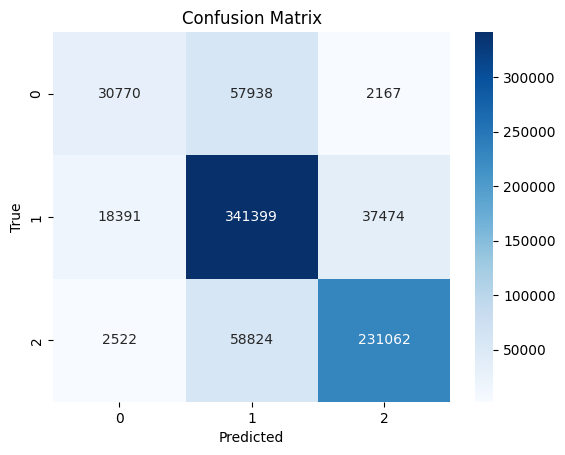

In [12]:
# make a confusion matrix
confusion_matrix = pd.crosstab(CNN_S_CLS_REG_test["masked_cls_targets"], CNN_S_CLS_REG_test["masked_cls_preds"], rownames=['True'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [13]:
spearmanr(CNN_S_CLS_REG_test["masked_regr_targets"], CNN_S_CLS_REG_test["masked_regr_preds"])

SignificanceResult(statistic=np.float64(0.8084824263975311), pvalue=np.float64(0.0))

In [14]:
mean_absolute_error(CNN_S_CLS_REG_test["masked_regr_targets"], CNN_S_CLS_REG_test["masked_regr_preds"])

0.41814738512039185

In [15]:
r2_score(CNN_S_CLS_REG_test["masked_regr_targets"], CNN_S_CLS_REG_test["masked_regr_preds"])

0.6520265340805054

Text(0, 0.5, 'CNN-S-CLS-REG Predicted frustration')

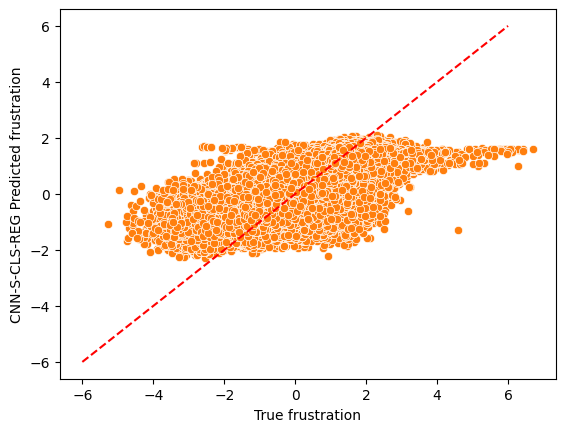

In [16]:
sns.scatterplot(x=CNN_S_CLS_REG_test["masked_regr_targets"], y=CNN_S_CLS_REG_test["masked_regr_preds"], color="C1")
plt.plot([-6, 6], [-6, 6], color="red", linestyle="--")
plt.xlabel("True frustration")
plt.ylabel("CNN-S-CLS-REG Predicted frustration")

Text(39.222222222222214, 0.5, 'CNN-S-CLS-REG Predicted frustration')

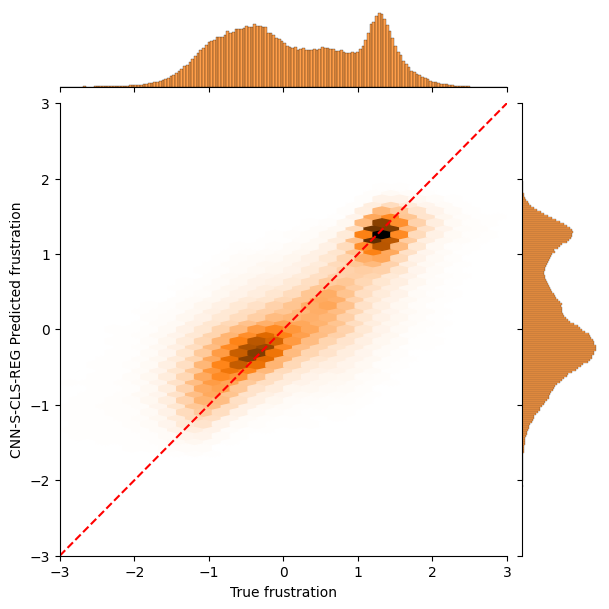

In [17]:
sns.jointplot(x=CNN_S_CLS_REG_test["masked_regr_targets"], y=CNN_S_CLS_REG_test["masked_regr_preds"], kind="hex", xlim=(-3,3), ylim=(-3,3), color="C1")
plt.plot([-3, 3], [-3, 3], color="red", linestyle="--")
plt.xlabel("True frustration")
plt.ylabel("CNN-S-CLS-REG Predicted frustration")

### CNN_S_REG

In [18]:
CNN_S_REG_test = np.load("../data/it3-5_S/it3-5_S_reg_protT5_test_preds.npz")
CNN_S_REG_test.files

['full_seqs',
 'masks',
 'regr_preds',
 'regr_targets',
 'masked_regr_preds',
 'masked_regr_targets']

In [19]:
CNN_S_REG_test["full_seqs"].shape, CNN_S_REG_test["masks"].shape, CNN_S_REG_test["regr_preds"].shape, CNN_S_REG_test["masked_regr_preds"].shape

((5000,), (5000, 512), (5000, 512), (780547,))

In [20]:
padded_seqs = []
for seq in CNN_S_REG_test["full_seqs"]:
    if len(seq) < 512:
        # Pad the sequence
        padding = "X" * (512 - len(seq))
        padded_seqs.append(seq + padding)
    else:
        # Truncate the sequence
        padded_seqs.append(seq[:512])
padded_seqs = np.array(padded_seqs)
padded_seqs.shape

(5000,)

In [21]:
CNN_S_REG_test["masks"].shape

(5000, 512)

In [22]:
seq_array = np.array([list(seq) for seq in padded_seqs])
seq_array.shape

(5000, 512)

In [23]:
masked_residues = seq_array[CNN_S_REG_test["masks"]]
masked_residues.shape

(780547,)

In [24]:
masked_residues

array(['R', 'Q', 'E', ..., 'A', 'E', 'E'], shape=(780547,), dtype='<U1')

In [25]:
cls_preds = pd.cut(CNN_S_REG_test["masked_regr_preds"].astype(float), bins=[-np.inf, -1, 0.55, np.inf], labels=[0,1,2])
cls_preds.shape

(780547,)

In [26]:
np.unique(cls_preds, return_counts=True)

(array([0, 1, 2]), array([ 35057, 498830, 246660]))

In [27]:
CNN_S_REG_report = classification_report(CNN_S_CLS_REG_test["masked_cls_targets"], 
                                        cls_preds, 
                                        labels=range(3), digits=4, zero_division=0)

In [28]:
print(CNN_S_REG_report)

              precision    recall  f1-score   support

           0     0.6469    0.2496    0.3602     90875
           1     0.7209    0.9052    0.8026    397264
           2     0.8888    0.7497    0.8133    292408

    accuracy                         0.7706    780547
   macro avg     0.7522    0.6348    0.6587    780547
weighted avg     0.7752    0.7706    0.7551    780547



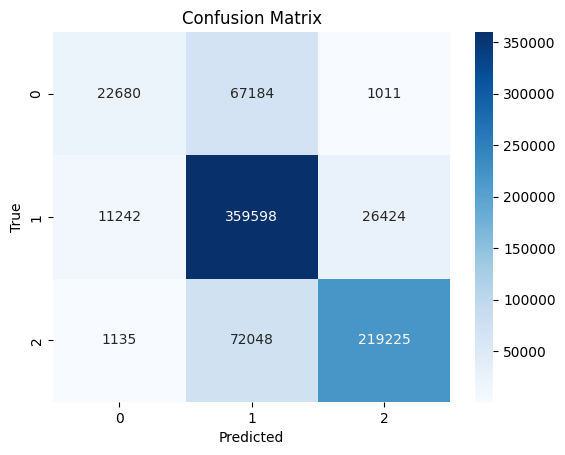

In [31]:
# make a confusion matrix
confusion_matrix = pd.crosstab(CNN_S_CLS_REG_test["masked_cls_targets"], cls_preds, rownames=['True'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [11]:
spearmanr(CNN_S_CLS_REG_test["masked_regr_targets"], CNN_S_CLS_REG_test["masked_regr_preds"])

SignificanceResult(statistic=np.float64(0.8098929267213707), pvalue=np.float64(0.0))

In [12]:
mean_absolute_error(CNN_S_CLS_REG_test["masked_regr_targets"], CNN_S_CLS_REG_test["masked_regr_preds"])

0.4125500023365021

In [13]:
r2_score(CNN_S_CLS_REG_test["masked_regr_targets"], CNN_S_CLS_REG_test["masked_regr_preds"])

0.6573473215103149

Text(0, 0.5, 'CNN-S-CLS-REG Predicted frustration')

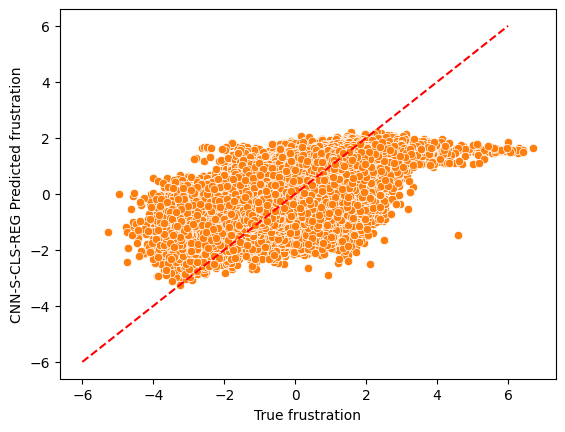

In [14]:
sns.scatterplot(x=CNN_S_CLS_REG_test["masked_regr_targets"], y=CNN_S_CLS_REG_test["masked_regr_preds"], color="C1")
plt.plot([-6, 6], [-6, 6], color="red", linestyle="--")
plt.xlabel("True frustration")
plt.ylabel("CNN-S-CLS-REG Predicted frustration")

Text(39.222222222222214, 0.5, 'CNN-S-CLS-REG Predicted frustration')

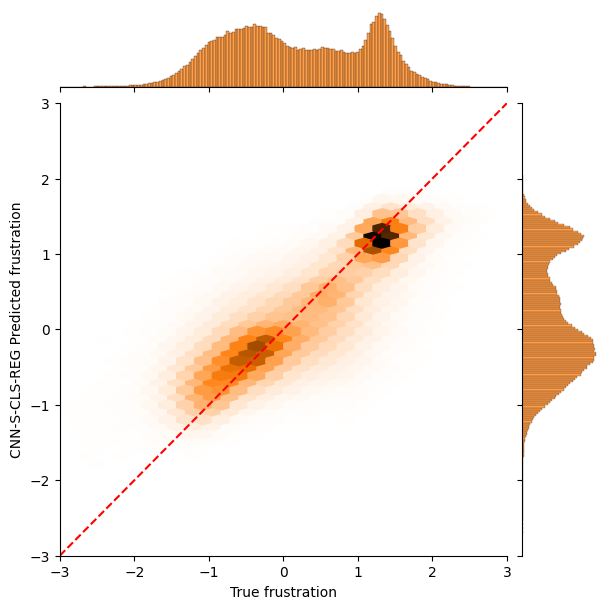

In [15]:
sns.jointplot(x=CNN_S_CLS_REG_test["masked_regr_targets"], y=CNN_S_CLS_REG_test["masked_regr_preds"], kind="hex", xlim=(-3,3), ylim=(-3,3), color="C1")
plt.plot([-3, 3], [-3, 3], color="red", linestyle="--")
plt.xlabel("True frustration")
plt.ylabel("CNN-S-CLS-REG Predicted frustration")

### LORA QK PREDS

In [ ]:
lora_QK_test = np.load("../data/it3_lora/loraQK_test_preds.npz")
lora_QK_test.files

['full_seqs',
 'masks',
 'regr_preds',
 'cls_preds',
 'regr_targets',
 'cls_targets',
 'masked_regr_preds',
 'masked_cls_preds',
 'masked_regr_targets',
 'masked_cls_targets']

In [ ]:
lora_QK_test["full_seqs"].shape, lora_QK_test["masks"].shape, lora_QK_test["regr_preds"].shape, lora_QK_test["masked_regr_preds"].shape

((56892,), (56892, 512), (56892, 512), (9575120,))

In [ ]:
padded_seqs = []
for seq in lora_QK_test["full_seqs"]:
    if len(seq) < 512:
        # Pad the sequence
        padding = "X" * (512 - len(seq))
        padded_seqs.append(seq + padding)
    else:
        # Truncate the sequence
        padded_seqs.append(seq[:512])
padded_seqs = np.array(padded_seqs)
padded_seqs.shape

(56892,)

In [ ]:
lora_QK_test["masks"].shape

(56892, 512)

In [ ]:
seq_array = np.array([list(seq) for seq in padded_seqs])
seq_array.shape

(56892, 512)

In [ ]:
masked_residues = seq_array[lora_QK_test["masks"]]
masked_residues.shape

(9575120,)

In [ ]:
masked_residues

array(['A', 'K', 'A', ..., 'E', 'Y', 'R'], shape=(9575120,), dtype='<U1')

In [ ]:
np.unique(lora_QK_test["masked_cls_preds"], return_counts=True)

(array([1, 2]), array([6111069, 3464051]))

In [ ]:
CNN_report = classification_report(lora_QK_test["masked_cls_targets"], 
                                   lora_QK_test["masked_cls_preds"], 
                                   labels=range(3), digits=4, zero_division=0)

In [ ]:
print(CNN_report)

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000   1079124
           1     0.7234    0.9080    0.8053   4868864
           2     0.8632    0.8243    0.8433   3627132

    accuracy                         0.7740   9575120
   macro avg     0.5289    0.5774    0.5495   9575120
weighted avg     0.6948    0.7740    0.7289   9575120



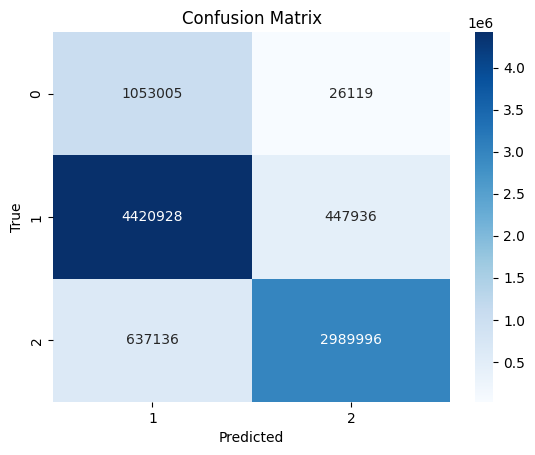

In [ ]:
# make a confusion matrix
confusion_matrix = pd.crosstab(lora_QK_test["masked_cls_targets"], lora_QK_test["masked_cls_preds"], rownames=['True'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
spearmanr(lora_QK_test["masked_regr_targets"], lora_QK_test["masked_regr_preds"])

SignificanceResult(statistic=np.float64(0.835594479982893), pvalue=np.float64(0.0))

In [ ]:
mean_absolute_error(lora_QK_test["masked_regr_targets"], lora_QK_test["masked_regr_preds"])

0.3775078356266022

In [ ]:
r2_score(lora_QK_test["masked_regr_targets"], lora_QK_test["masked_regr_preds"])

0.6966449022293091

Text(0, 0.5, 'LoRA-QK Predicted frustration')

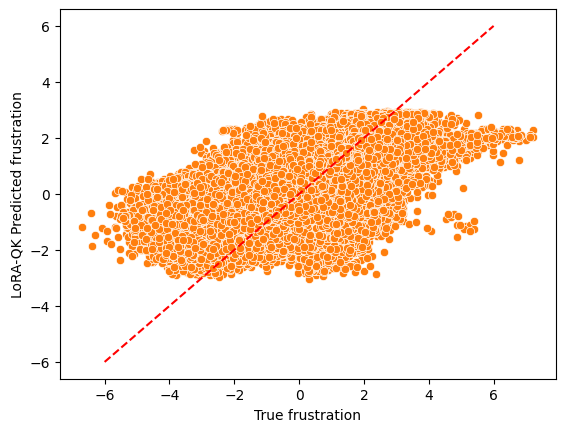

In [ ]:
sns.scatterplot(x=lora_QK_test["masked_regr_targets"], y=lora_QK_test["masked_regr_preds"], color="C1")
plt.plot([-6, 6], [-6, 6], color="red", linestyle="--")
plt.xlabel("True frustration")
plt.ylabel("LoRA-QK Predicted frustration")

Text(39.222222222222214, 0.5, 'CNN Predicted frustration')

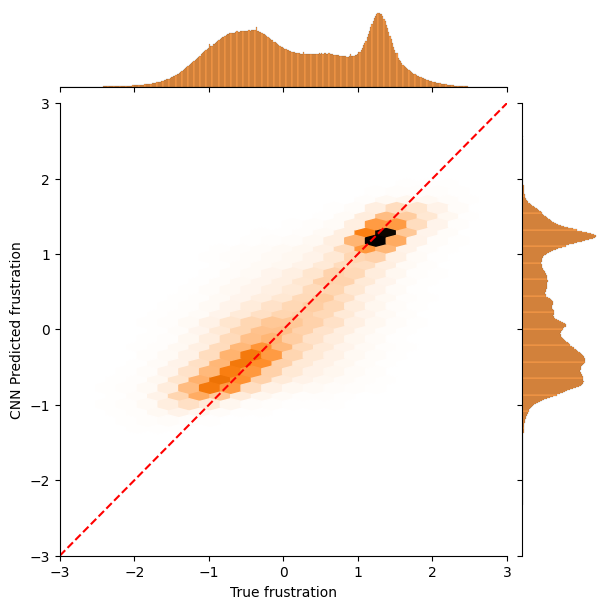

In [ ]:
sns.jointplot(x=lora_QK_test["masked_regr_targets"], y=lora_QK_test["masked_regr_preds"], kind="hex", xlim=(-3,3), ylim=(-3,3), color="C1")
plt.plot([-3, 3], [-3, 3], color="red", linestyle="--")
plt.xlabel("True frustration")
plt.ylabel("CNN Predicted frustration")

In [ ]:
mask = lora_QK_test["cls_targets"] != 0

In [ ]:
pp_spearman = Parallel(n_jobs=-1)(
    delayed(spearmanr)(targets[m], preds[m])
    for preds, targets, m in zip(lora_QK_test["regr_preds"], lora_QK_test["regr_targets"], mask)
)
pp_spearman = np.array(pp_spearman)

/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/joblib/parallel.py:607: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return [func(*args, **kwargs) for func, args, kwargs in self.items]
/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/joblib/parallel.py:607: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return [func(*args, **kwargs) for func, args, kwargs in self.items]
/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/joblib/parallel.py:607: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return [func(*args, **kwargs) for func, args, kwargs in self.items]
/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/joblib/parallel.py:607: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return [func(*args, **kwargs

<Axes: ylabel='Count'>

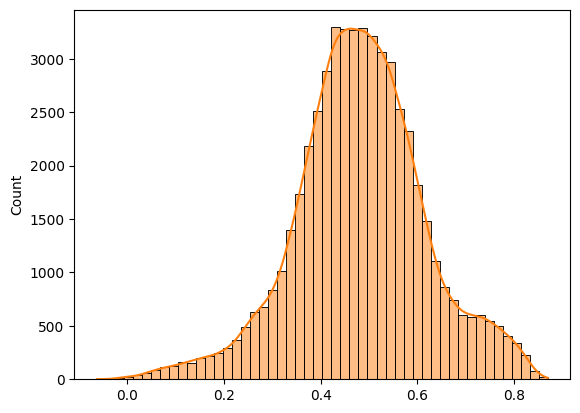

In [ ]:
sns.histplot(pp_spearman[:, 0], bins=50, color="C1", kde=True)

In [ ]:
sum(pp_spearman[:, 0] <= 0)

np.int64(26)

In [ ]:
def mae_row(targets, preds):
    if len(targets) == 0 or len(preds) == 0:
        return np.nan
    return mean_absolute_error(targets, preds)

In [ ]:
pp_mae = Parallel(n_jobs=-1)(
    delayed(mae_row)(targets[m], preds[m])
    for preds, targets, m in zip(lora_QK_test["regr_preds"], lora_QK_test["regr_targets"], mask)
)
pp_mae = np.array(pp_mae)

<Axes: ylabel='Count'>

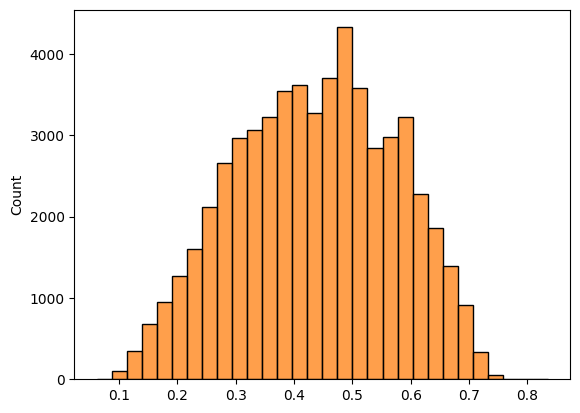

In [ ]:
sns.histplot(pp_mae, bins=30, color="C1")

In [ ]:
res_df = pd.DataFrame({"regr_pred": lora_QK_test["masked_regr_preds"],
                       "true_reg": lora_QK_test["masked_regr_targets"],
                       "cls_pred": lora_QK_test["masked_cls_preds"],
                       "cls_target": lora_QK_test["masked_cls_targets"],
                       "residue": masked_residues,
                       })
res_df

,regr_pred,true_reg,cls_pred,cls_target,residue
0,0.031655,-0.879,1,1,A
1,1.328626,1.250,2,2,K
2,0.640119,-0.937,2,1,A
3,0.078500,1.204,1,2,E
4,0.315636,0.978,1,2,E
...,...,...,...,...,...
9575115,1.230610,1.149,2,2,L
9575116,-0.891374,-1.287,1,0,E
9575117,-0.579436,-0.010,1,1,E
9575118,-0.477728,-1.478,1,0,Y


In [ ]:
res_df_sub = res_df.sample(1000000, random_state=42)
res_df_sub

,regr_pred,true_reg,cls_pred,cls_target,residue
3387255,-0.247734,0.104,1,1,W
4535045,-0.680318,-1.219,1,0,N
6532567,-0.041693,1.173,1,2,Q
2193737,0.165828,-0.441,1,1,K
5278402,1.236696,1.326,2,2,V
...,...,...,...,...,...
6851893,-0.911659,-1.144,1,0,K
9177927,-0.592627,-0.660,1,1,E
3907879,-0.635298,-1.408,1,0,Q
1066758,-0.443592,-0.815,1,1,G


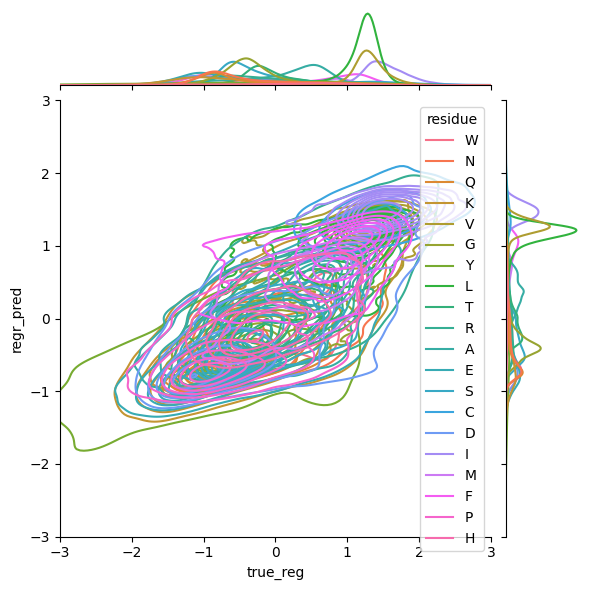

In [ ]:
sns.jointplot(data=res_df_sub, x="true_reg", y="regr_pred", hue="residue", kind="kde", xlim=(-3,3), ylim=(-3,3))

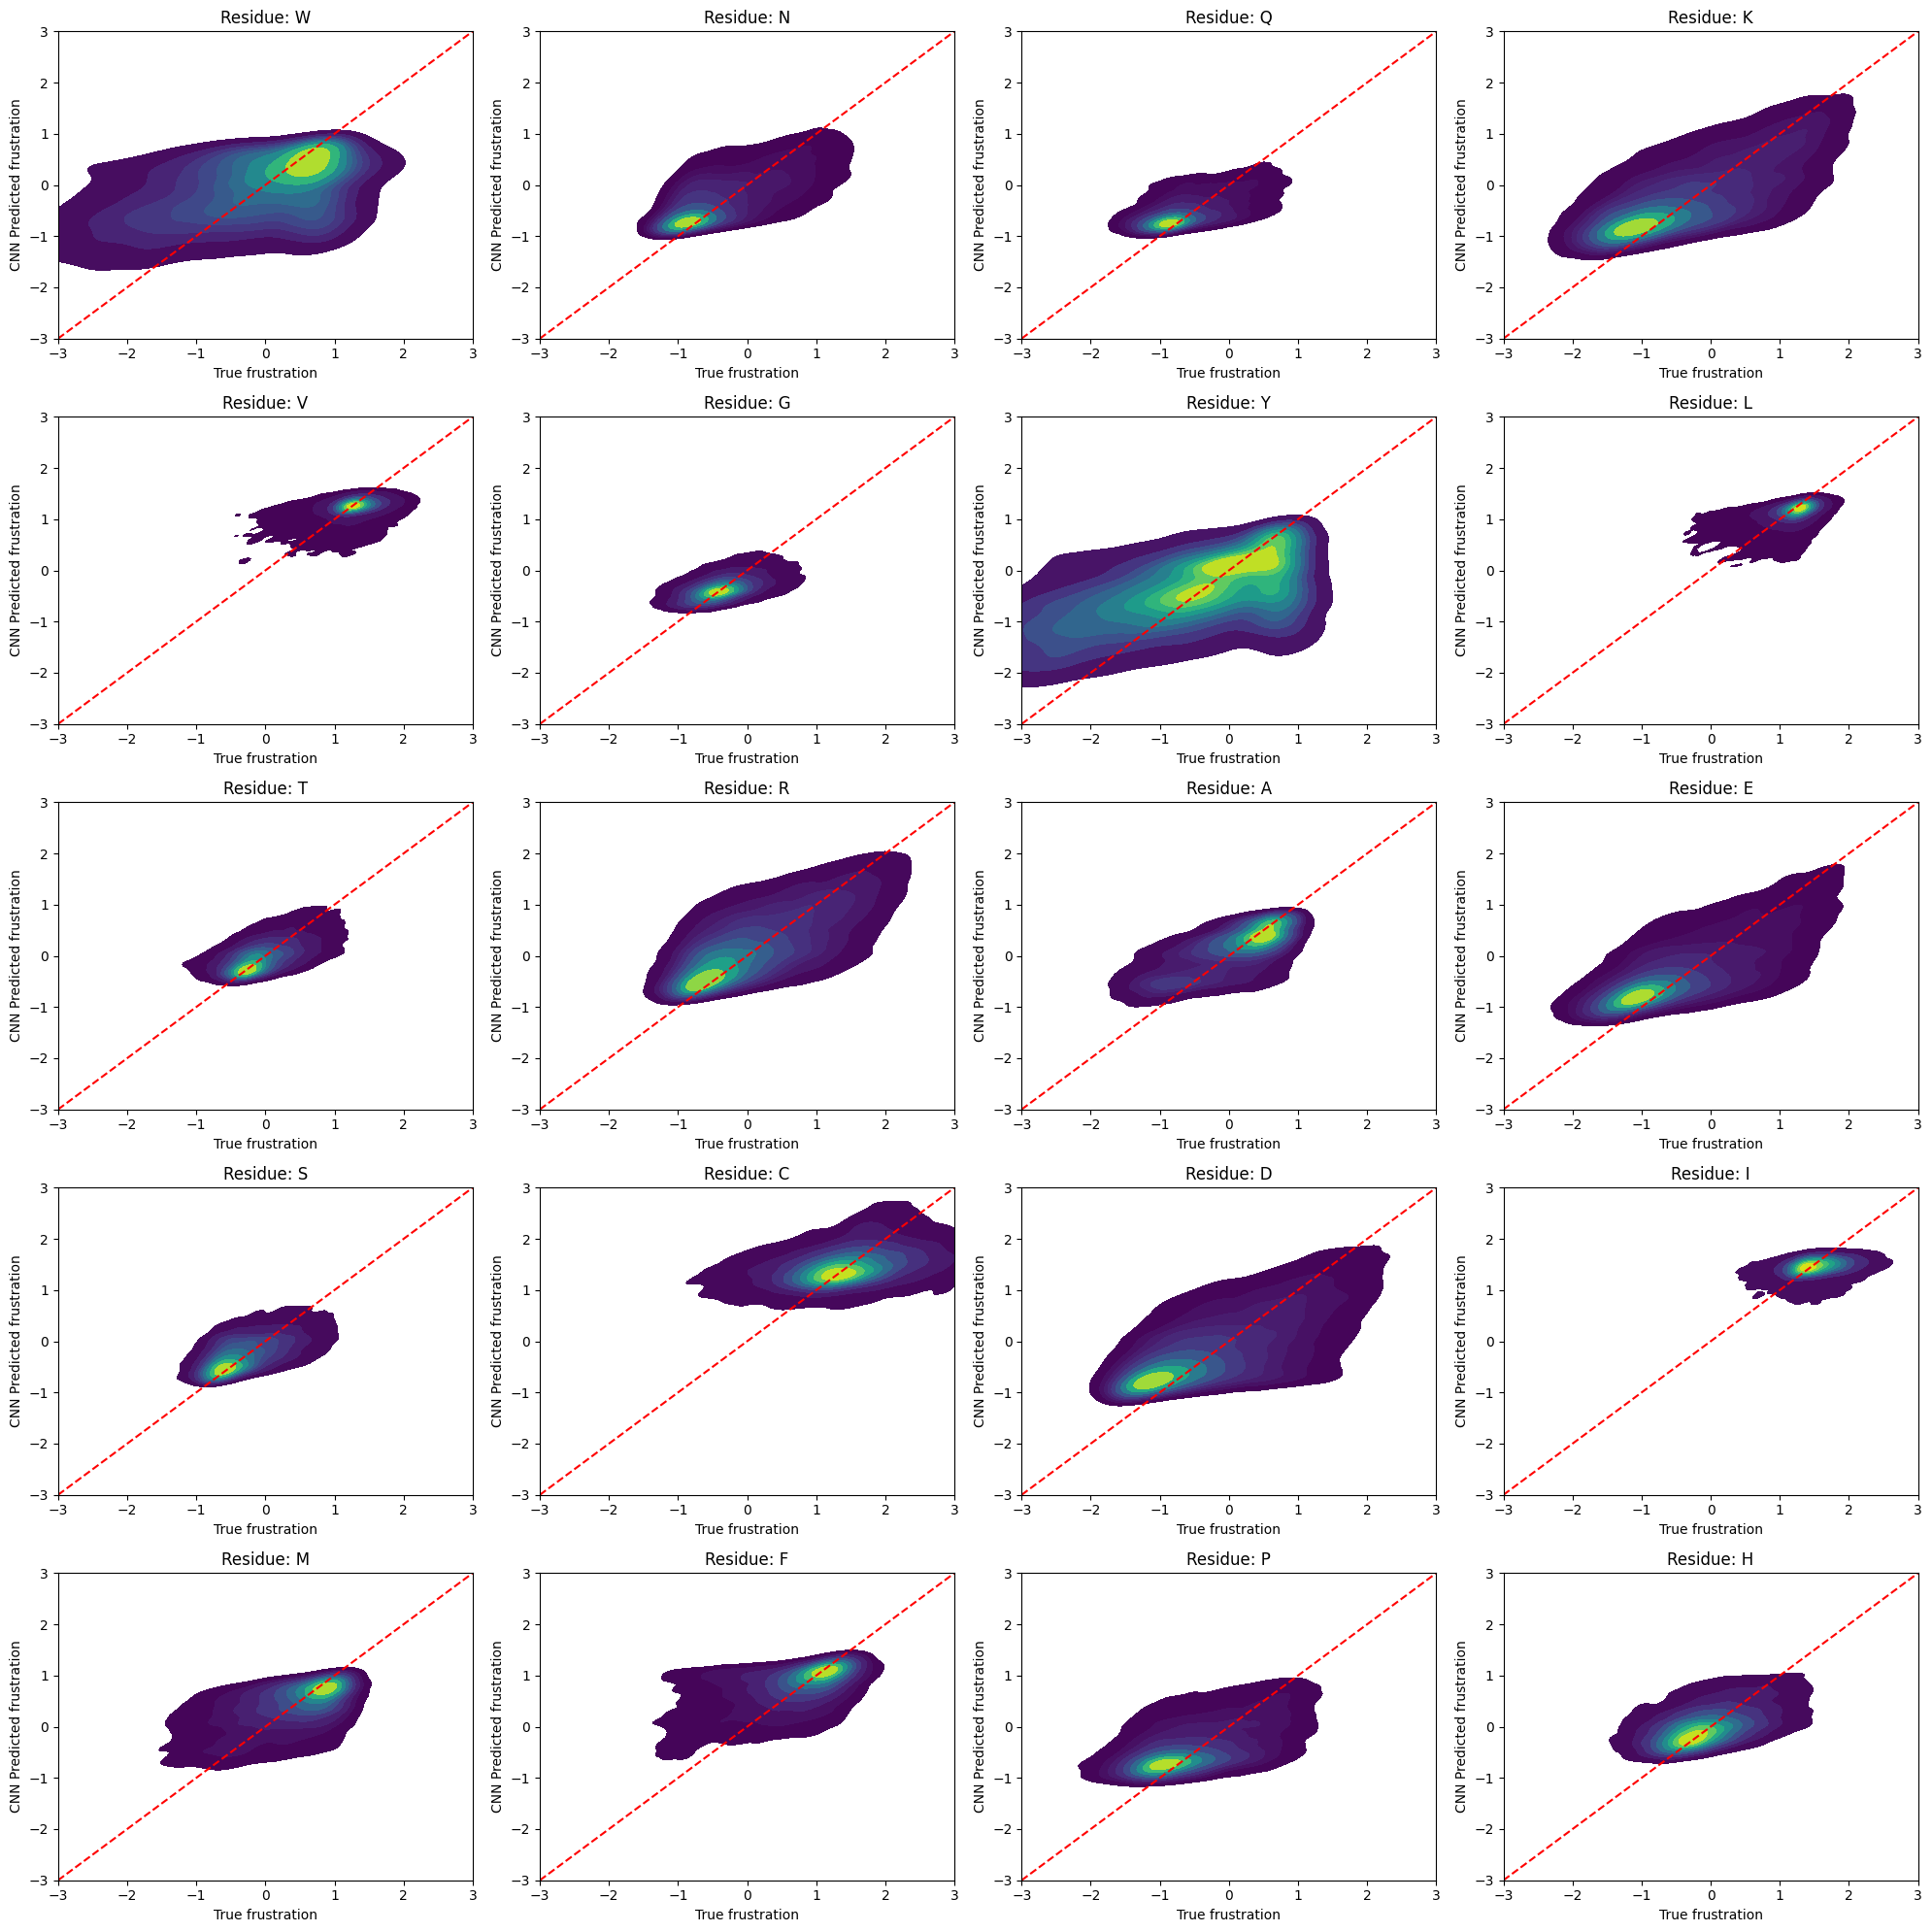

In [ ]:
#make a fig with 20 subplots 5rows and 4 columns showing jointplots for each residue type
fig, axes = plt.subplots(5, 4, figsize=(20, 20))
residues = res_df_sub["residue"].unique()
for i, residue in enumerate(residues):
    ax = axes[i // 4, i % 4]
    subset = res_df_sub[res_df_sub["residue"] == residue]
    sns.kdeplot(data=subset, x="true_reg", y="regr_pred", fill=True, ax=ax, cmap="viridis")
    ax.plot([-3, 3], [-3, 3], color="red", linestyle="--")
    ax.set_title(f'Residue: {residue}')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_xlabel("True frustration")
    ax.set_ylabel("CNN Predicted frustration")
plt.tight_layout()
plt.show()

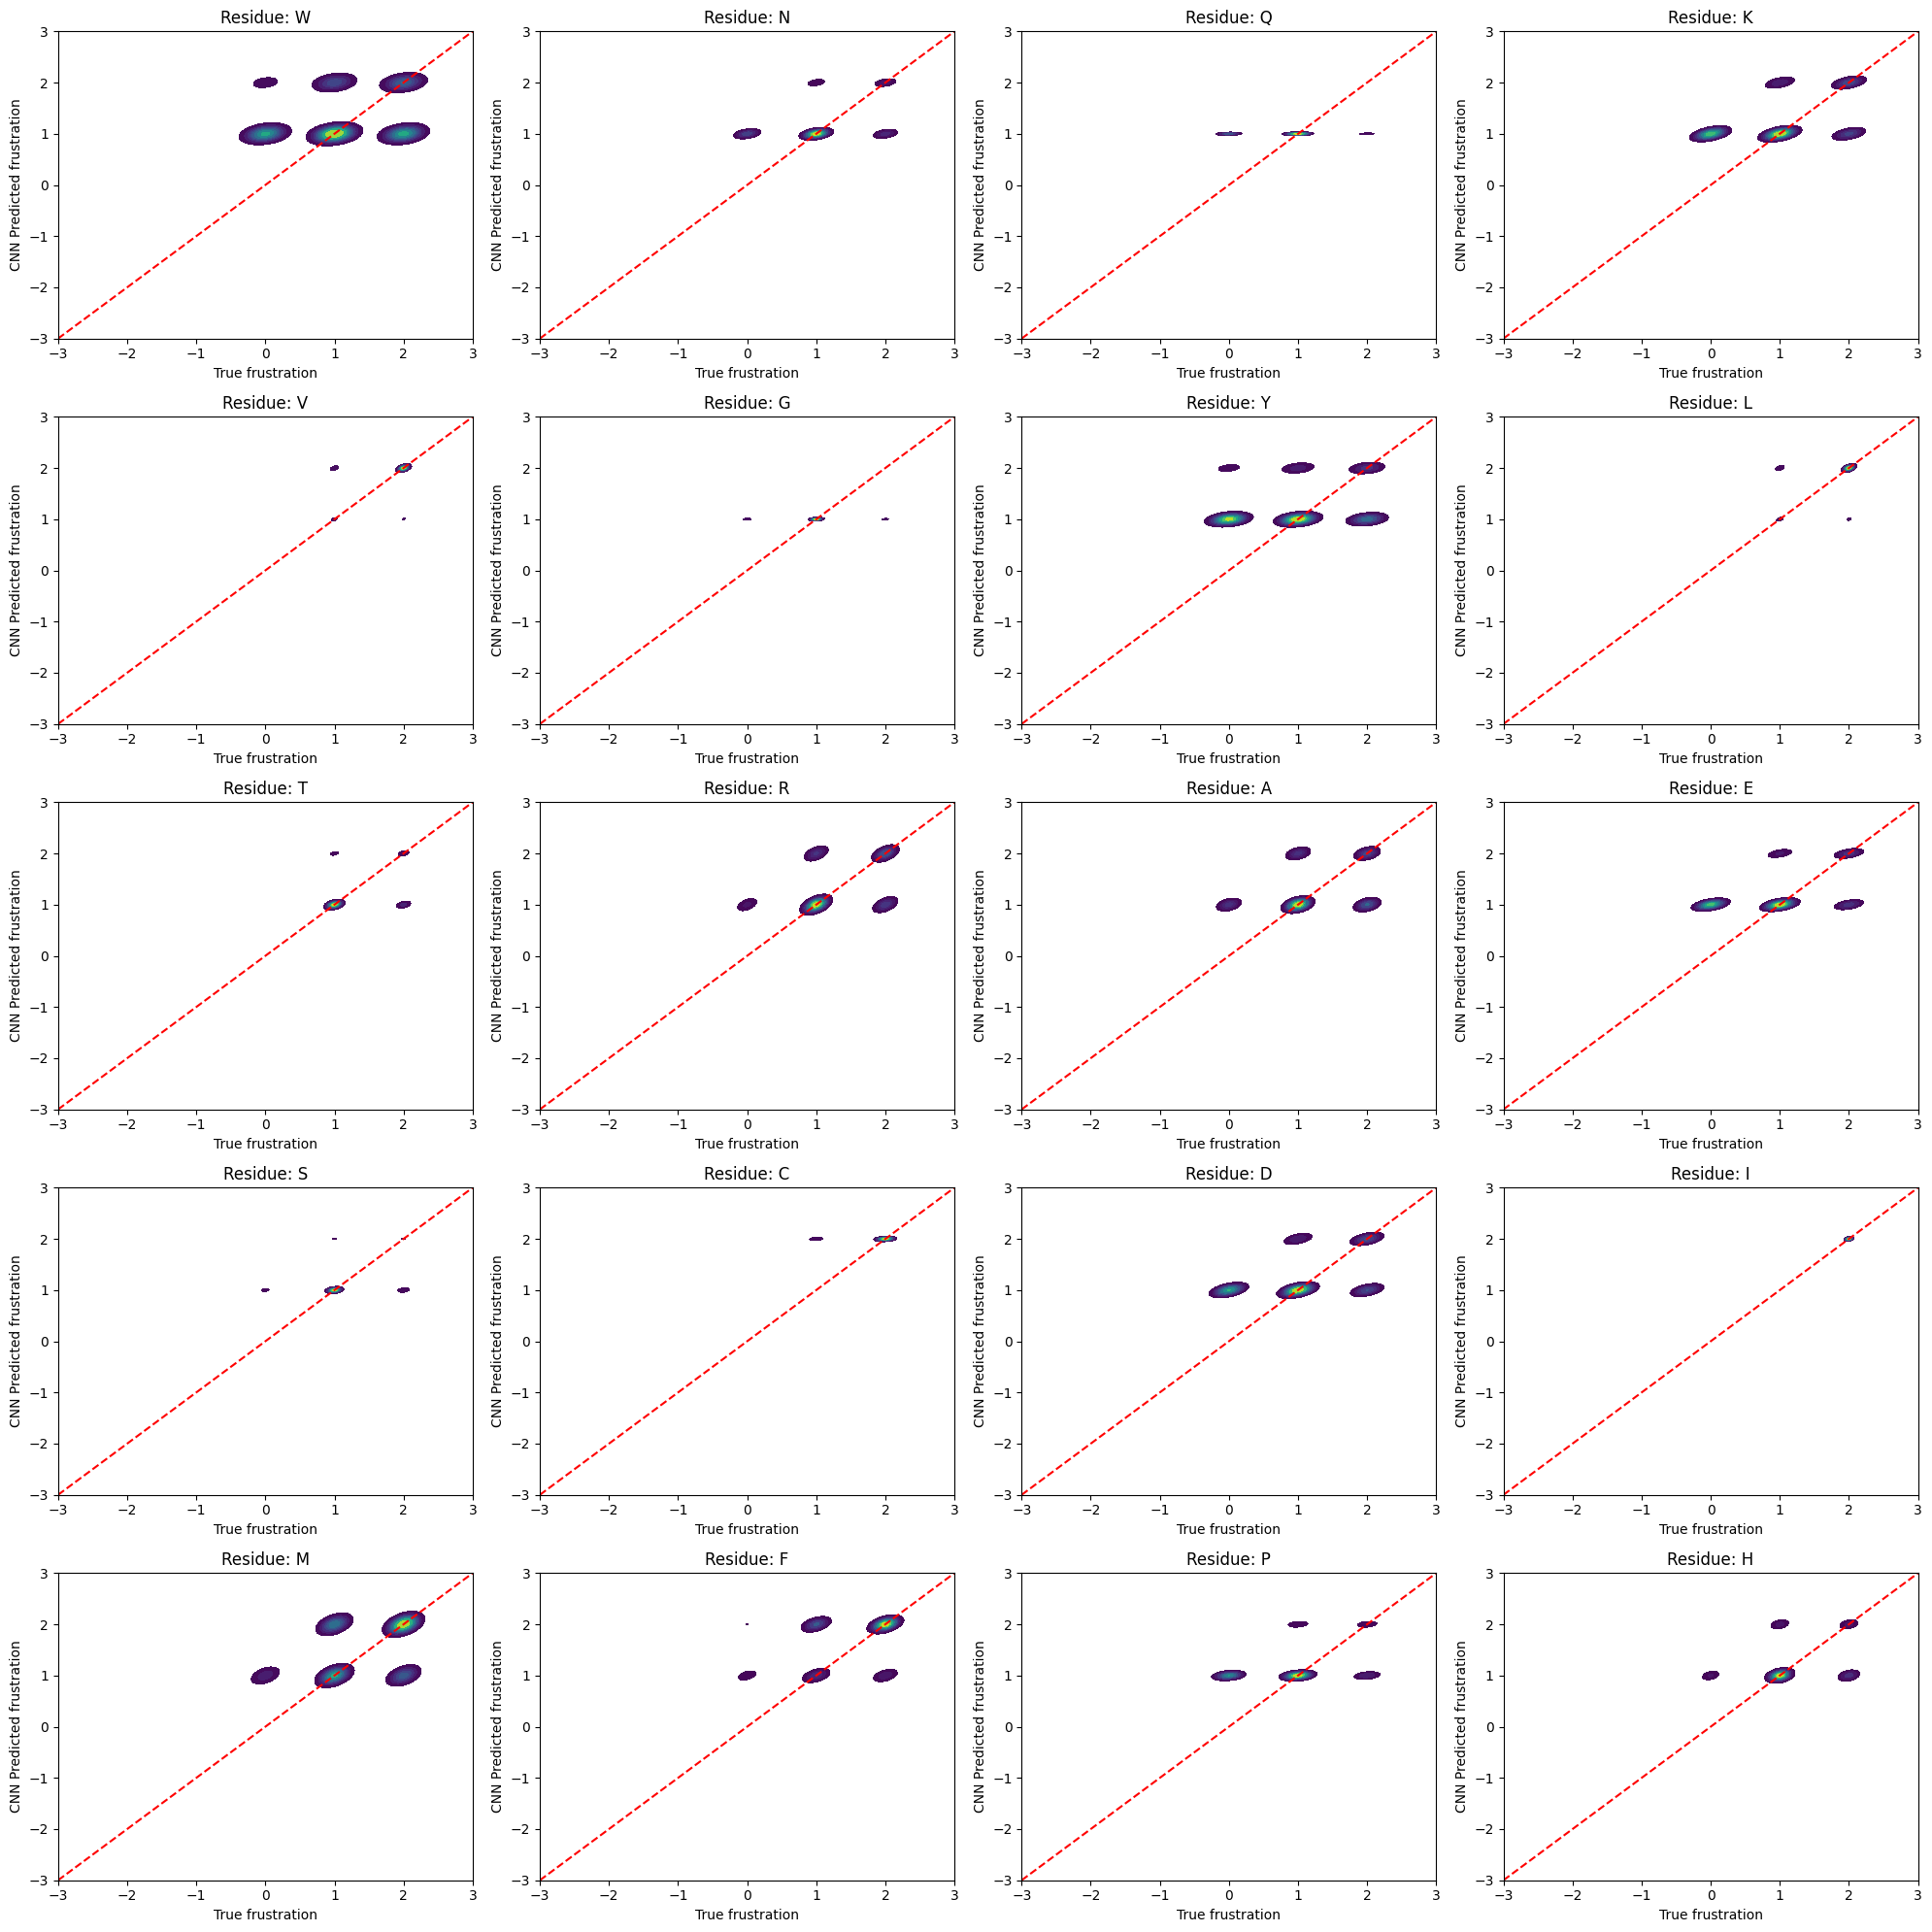

In [ ]:
#make a fig with 20 subplots 5rows and 4 columns showing jointplots for each residue type
fig, axes = plt.subplots(5, 4, figsize=(20, 20))
residues = res_df_sub["residue"].unique()
for i, residue in enumerate(residues):
    ax = axes[i // 4, i % 4]
    subset = res_df_sub[res_df_sub["residue"] == residue]
    sns.kdeplot(data=subset, x="cls_target", y="cls_pred", fill=True, ax=ax, cmap="viridis")
    ax.plot([-3, 3], [-3, 3], color="red", linestyle="--")
    ax.set_title(f'Residue: {residue}')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_xlabel("True frustration")
    ax.set_ylabel("CNN Predicted frustration")
plt.tight_layout()
plt.show()

In [ ]:
residues = res_df_sub["residue"].unique()
for i, residue in enumerate(residues):
    subset = res_df_sub[res_df_sub["residue"] == residue]
    cls_report = classification_report(subset["cls_target"], subset["cls_pred"], labels=range(3), digits=4, zero_division=0)
    print(f"Residue: {residue}")
    print(cls_report)

Residue: W
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      2832
           1     0.4694    0.8019    0.5921      5846
           2     0.5324    0.3680    0.4352      4242

    accuracy                         0.4837     12920
   macro avg     0.3339    0.3900    0.3424     12920
weighted avg     0.3872    0.4837    0.4108     12920

Residue: N
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      6894
           1     0.7562    0.9617    0.8467     34694
           2     0.6266    0.3680    0.4637      6146

    accuracy                         0.7464     47734
   macro avg     0.4609    0.4433    0.4368     47734
weighted avg     0.6303    0.7464    0.6751     47734

Residue: Q
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      7434
           1     0.7517    0.9958    0.8567     26040
           2     0.5363    0.1047    0.175

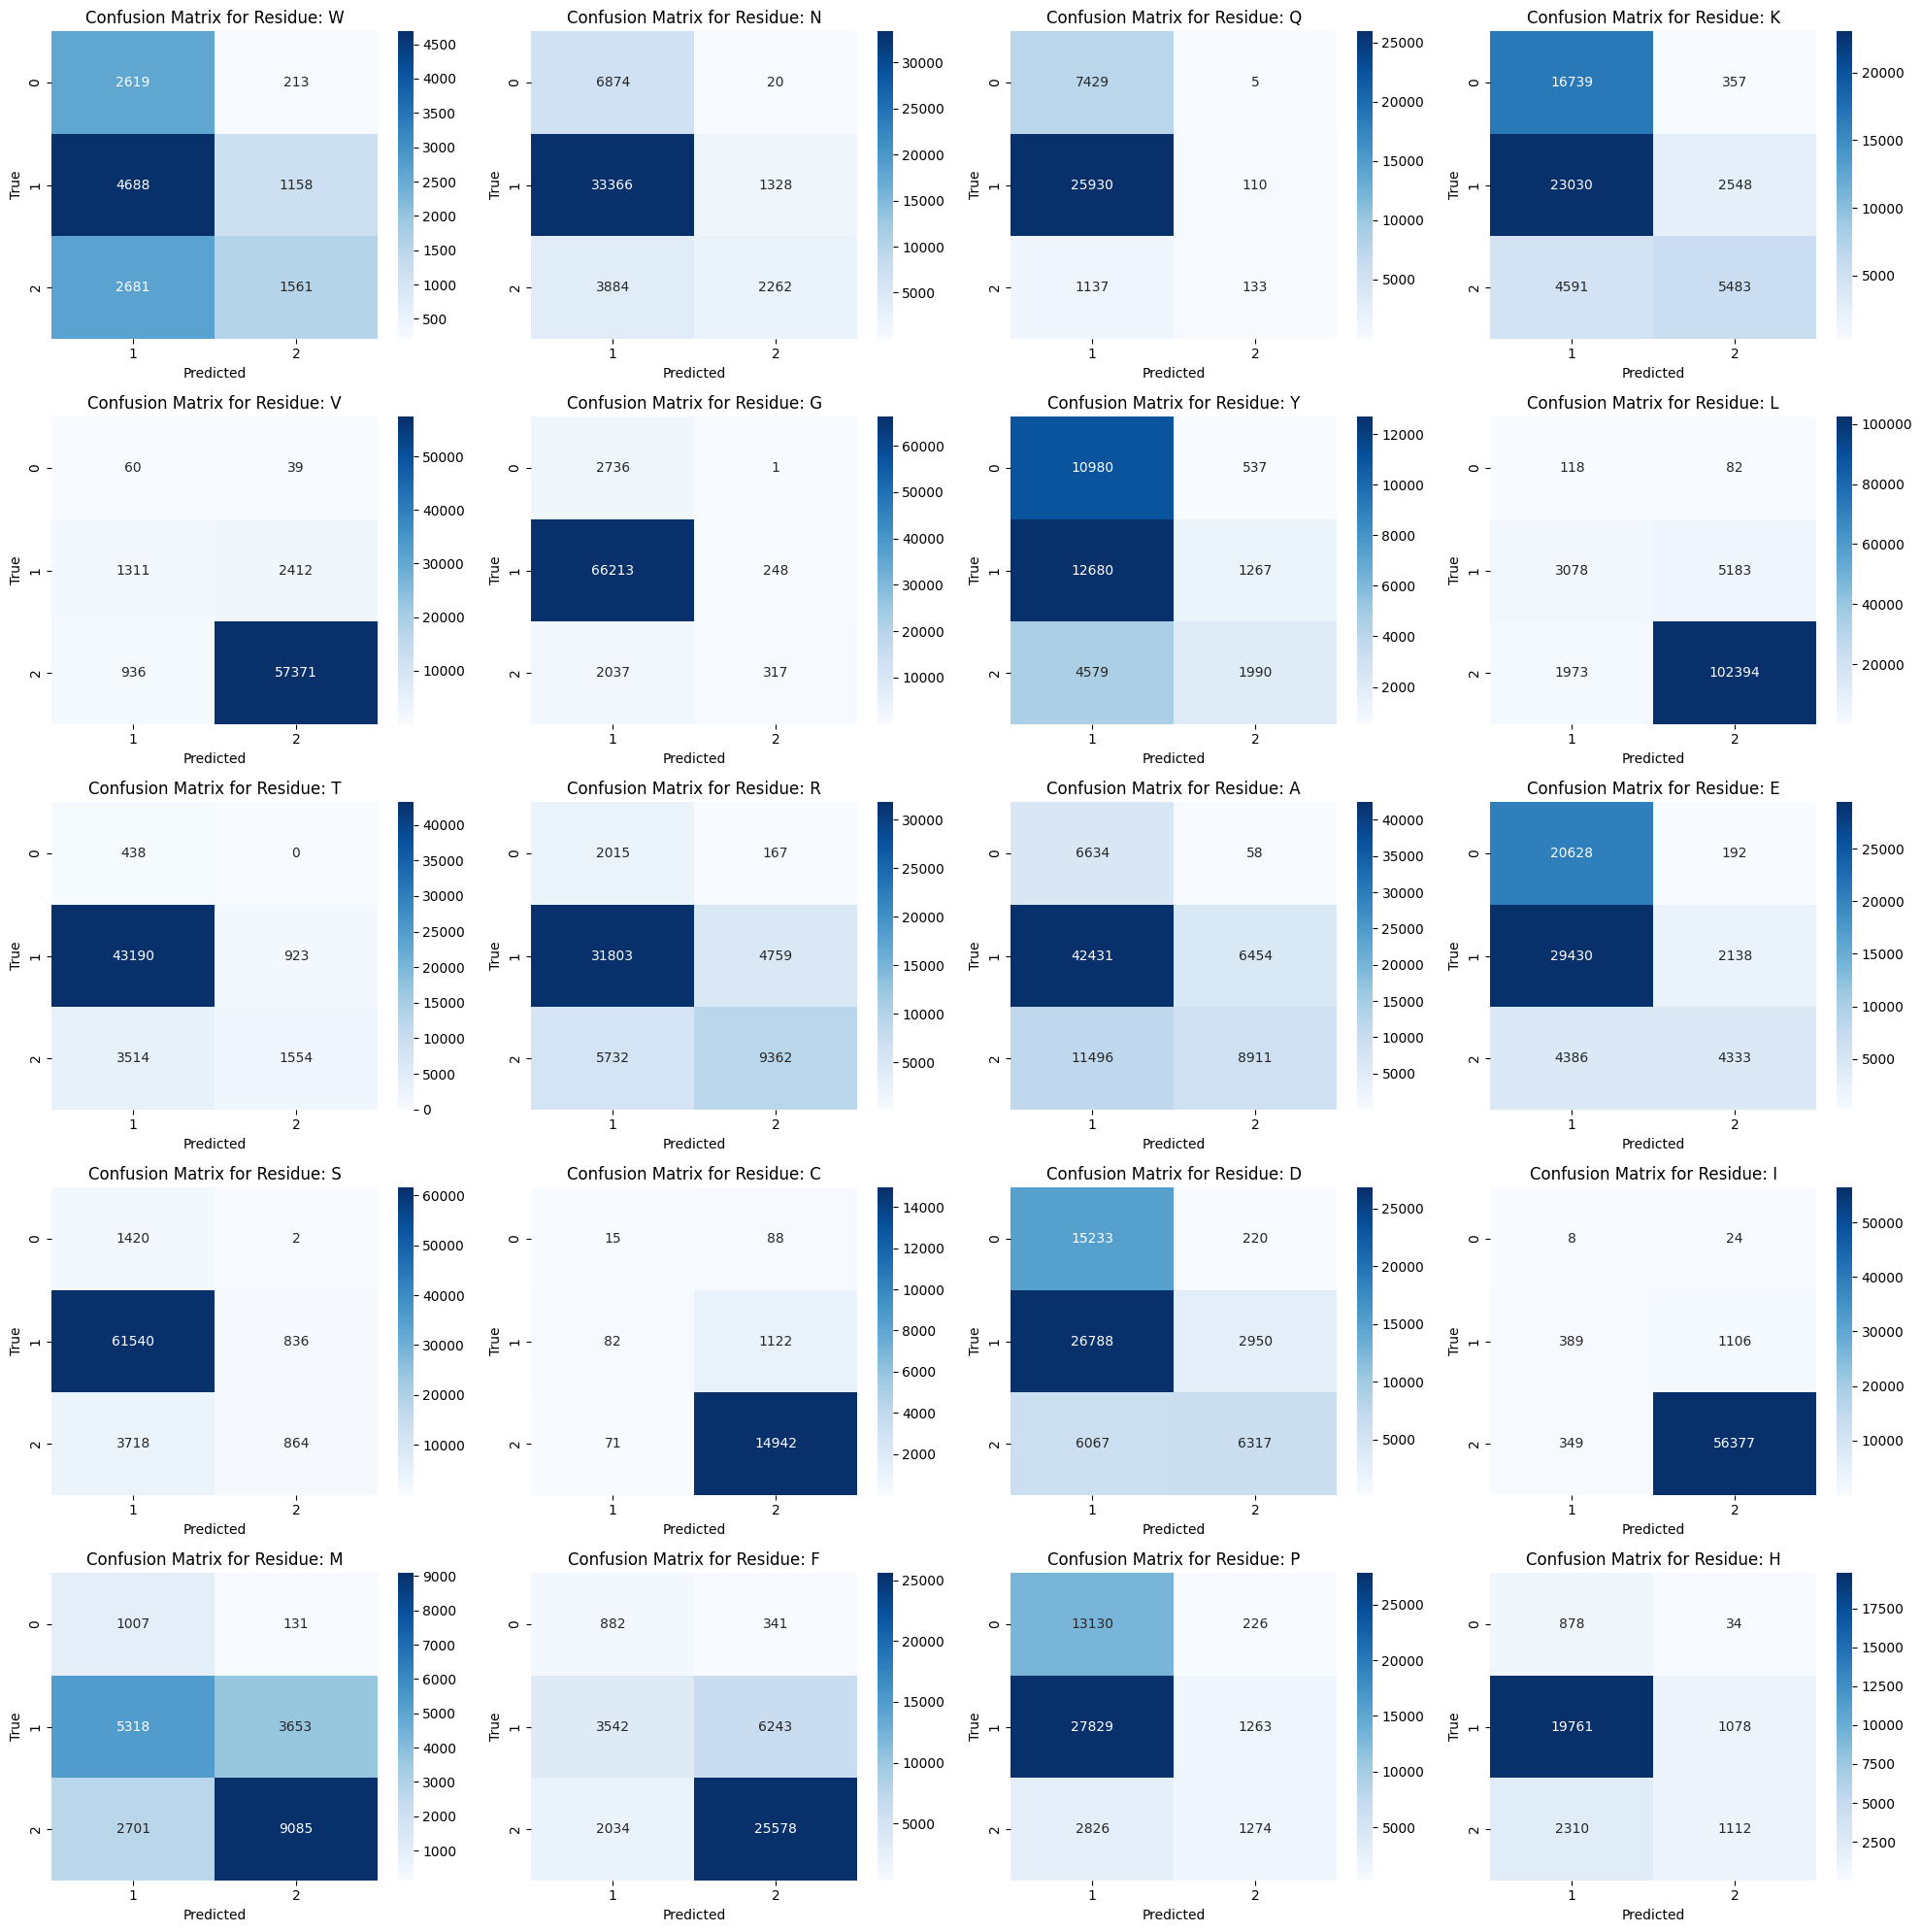

In [ ]:
fig, axes = plt.subplots(5, 4, figsize=(20, 20))
residues = res_df_sub["residue"].unique()
for i, residue in enumerate(residues):
    subset = res_df_sub[res_df_sub["residue"] == residue]
    confusion_matrix = pd.crosstab(subset["cls_target"], subset["cls_pred"], rownames=['True'], colnames=['Predicted'])
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[i // 4, i % 4])
    axes[i // 4, i % 4].set_title(f'Confusion Matrix for Residue: {residue}')
plt.tight_layout()
plt.show()

In [2]:
lora_QK_test = np.load("../data/it3_lora/loraQK_test_preds.npz")
lora_QK_test.files

['full_seqs',
 'masks',
 'regr_preds',
 'cls_preds',
 'regr_targets',
 'cls_targets',
 'masked_regr_preds',
 'masked_cls_preds',
 'masked_regr_targets',
 'masked_cls_targets']

In [3]:
lora_QK_test["full_seqs"].shape, lora_QK_test["masks"].shape, lora_QK_test["regr_preds"].shape, lora_QK_test["masked_regr_preds"].shape

((56892,), (56892, 512), (56892, 512), (9575120,))

In [4]:
padded_seqs = []
for seq in lora_QK_test["full_seqs"]:
    if len(seq) < 512:
        # Pad the sequence
        padding = "X" * (512 - len(seq))
        padded_seqs.append(seq + padding)
    else:
        # Truncate the sequence
        padded_seqs.append(seq[:512])
padded_seqs = np.array(padded_seqs)
padded_seqs.shape

(56892,)

In [5]:
lora_QK_test["masks"].shape

(56892, 512)

In [6]:
seq_array = np.array([list(seq) for seq in padded_seqs])
seq_array.shape

(56892, 512)

In [7]:
masked_residues = seq_array[lora_QK_test["masks"]]
masked_residues.shape

(9575120,)

In [8]:
masked_residues

array(['A', 'K', 'A', ..., 'E', 'Y', 'R'], shape=(9575120,), dtype='<U1')

In [16]:
np.unique(lora_QK_test["masked_cls_preds"], return_counts=True)

(array([1, 2]), array([6111069, 3464051]))

In [50]:
CNN_report = classification_report(lora_QK_test["masked_cls_targets"], 
                                   lora_QK_test["masked_cls_preds"], 
                                   labels=range(3), digits=4, zero_division=0)

In [51]:
print(CNN_report)

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000   1079124
           1     0.7234    0.9080    0.8053   4868864
           2     0.8632    0.8243    0.8433   3627132

    accuracy                         0.7740   9575120
   macro avg     0.5289    0.5774    0.5495   9575120
weighted avg     0.6948    0.7740    0.7289   9575120



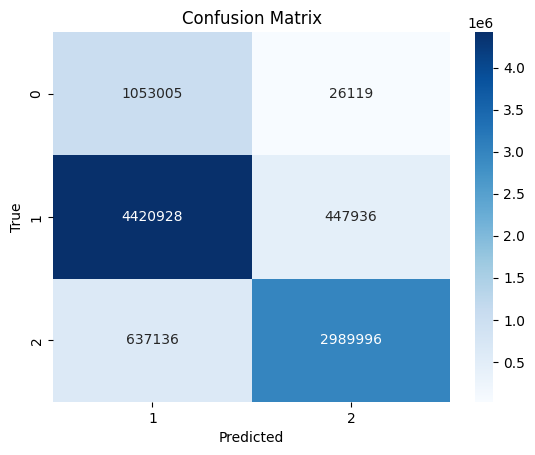

In [11]:
# make a confusion matrix
confusion_matrix = pd.crosstab(lora_QK_test["masked_cls_targets"], lora_QK_test["masked_cls_preds"], rownames=['True'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [12]:
spearmanr(lora_QK_test["masked_regr_targets"], lora_QK_test["masked_regr_preds"])

SignificanceResult(statistic=np.float64(0.835594479982893), pvalue=np.float64(0.0))

In [13]:
mean_absolute_error(lora_QK_test["masked_regr_targets"], lora_QK_test["masked_regr_preds"])

0.3775078356266022

In [14]:
r2_score(lora_QK_test["masked_regr_targets"], lora_QK_test["masked_regr_preds"])

0.6966449022293091

Text(0, 0.5, 'LoRA-QK Predicted frustration')

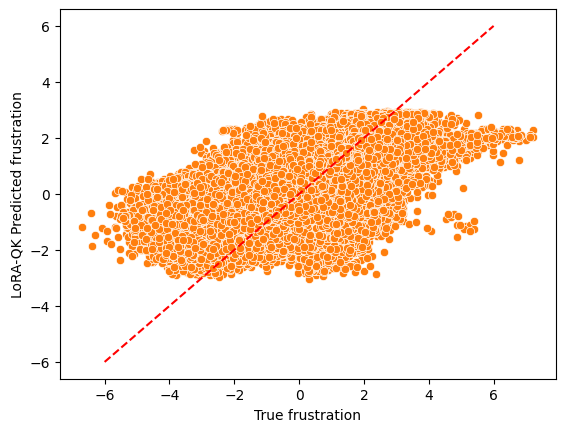

In [52]:
sns.scatterplot(x=lora_QK_test["masked_regr_targets"], y=lora_QK_test["masked_regr_preds"], color="C1")
plt.plot([-6, 6], [-6, 6], color="red", linestyle="--")
plt.xlabel("True frustration")
plt.ylabel("LoRA-QK Predicted frustration")

Text(39.222222222222214, 0.5, 'CNN Predicted frustration')

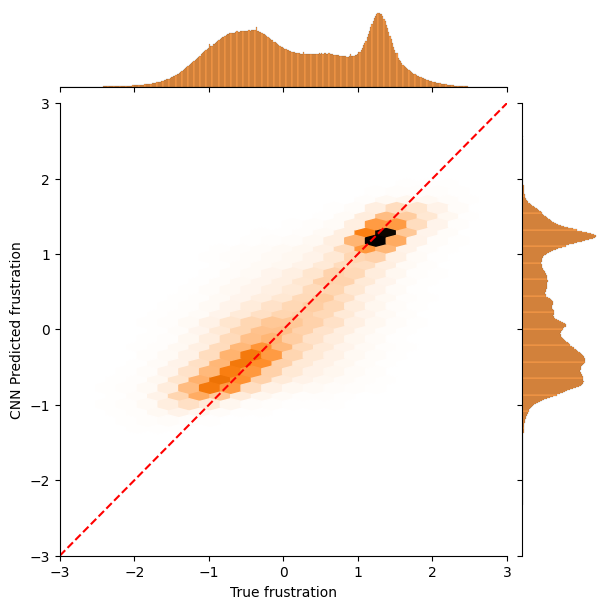

In [17]:
sns.jointplot(x=lora_QK_test["masked_regr_targets"], y=lora_QK_test["masked_regr_preds"], kind="hex", xlim=(-3,3), ylim=(-3,3), color="C1")
plt.plot([-3, 3], [-3, 3], color="red", linestyle="--")
plt.xlabel("True frustration")
plt.ylabel("CNN Predicted frustration")

In [18]:
mask = lora_QK_test["cls_targets"] != 0

In [19]:
pp_spearman = Parallel(n_jobs=-1)(
    delayed(spearmanr)(targets[m], preds[m])
    for preds, targets, m in zip(lora_QK_test["regr_preds"], lora_QK_test["regr_targets"], mask)
)
pp_spearman = np.array(pp_spearman)

/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/joblib/parallel.py:607: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return [func(*args, **kwargs) for func, args, kwargs in self.items]
/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/joblib/parallel.py:607: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return [func(*args, **kwargs) for func, args, kwargs in self.items]
/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/joblib/parallel.py:607: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return [func(*args, **kwargs) for func, args, kwargs in self.items]
/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/joblib/parallel.py:607: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return [func(*args, **kwargs

<Axes: ylabel='Count'>

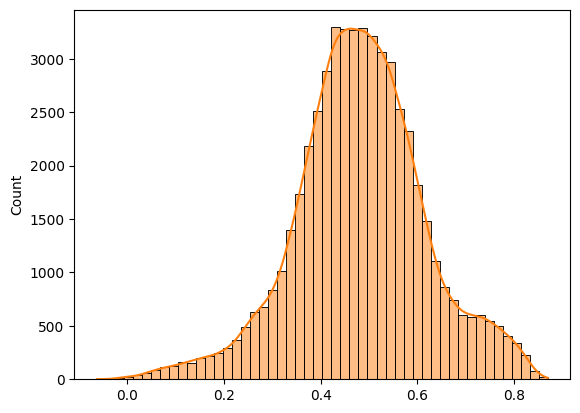

In [20]:
sns.histplot(pp_spearman[:, 0], bins=50, color="C1", kde=True)

In [21]:
sum(pp_spearman[:, 0] <= 0)

np.int64(26)

In [22]:
def mae_row(targets, preds):
    if len(targets) == 0 or len(preds) == 0:
        return np.nan
    return mean_absolute_error(targets, preds)

In [23]:
pp_mae = Parallel(n_jobs=-1)(
    delayed(mae_row)(targets[m], preds[m])
    for preds, targets, m in zip(lora_QK_test["regr_preds"], lora_QK_test["regr_targets"], mask)
)
pp_mae = np.array(pp_mae)

<Axes: ylabel='Count'>

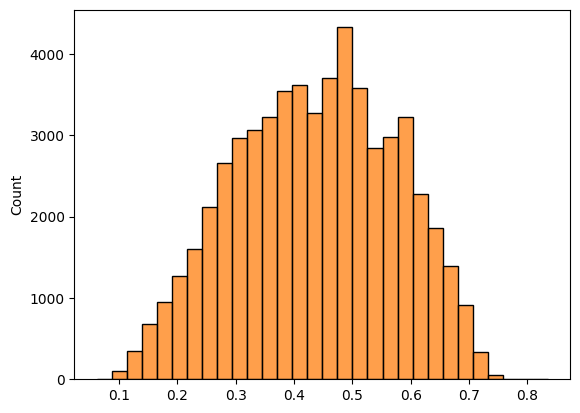

In [24]:
sns.histplot(pp_mae, bins=30, color="C1")

In [25]:
res_df = pd.DataFrame({"regr_pred": lora_QK_test["masked_regr_preds"],
                       "true_reg": lora_QK_test["masked_regr_targets"],
                       "cls_pred": lora_QK_test["masked_cls_preds"],
                       "cls_target": lora_QK_test["masked_cls_targets"],
                       "residue": masked_residues,
                       })
res_df

,regr_pred,true_reg,cls_pred,cls_target,residue
0,0.031655,-0.879,1,1,A
1,1.328626,1.250,2,2,K
2,0.640119,-0.937,2,1,A
3,0.078500,1.204,1,2,E
4,0.315636,0.978,1,2,E
...,...,...,...,...,...
9575115,1.230610,1.149,2,2,L
9575116,-0.891374,-1.287,1,0,E
9575117,-0.579436,-0.010,1,1,E
9575118,-0.477728,-1.478,1,0,Y


In [26]:
res_df_sub = res_df.sample(1000000, random_state=42)
res_df_sub

,regr_pred,true_reg,cls_pred,cls_target,residue
3387255,-0.247734,0.104,1,1,W
4535045,-0.680318,-1.219,1,0,N
6532567,-0.041693,1.173,1,2,Q
2193737,0.165828,-0.441,1,1,K
5278402,1.236696,1.326,2,2,V
...,...,...,...,...,...
6851893,-0.911659,-1.144,1,0,K
9177927,-0.592627,-0.660,1,1,E
3907879,-0.635298,-1.408,1,0,Q
1066758,-0.443592,-0.815,1,1,G


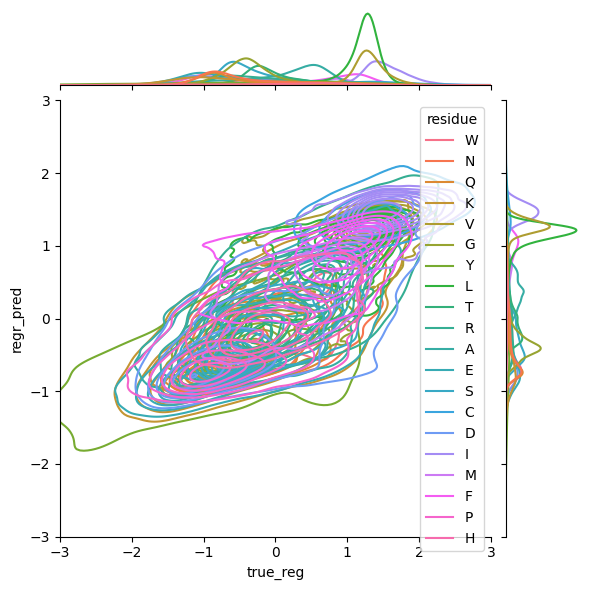

In [27]:
sns.jointplot(data=res_df_sub, x="true_reg", y="regr_pred", hue="residue", kind="kde", xlim=(-3,3), ylim=(-3,3))

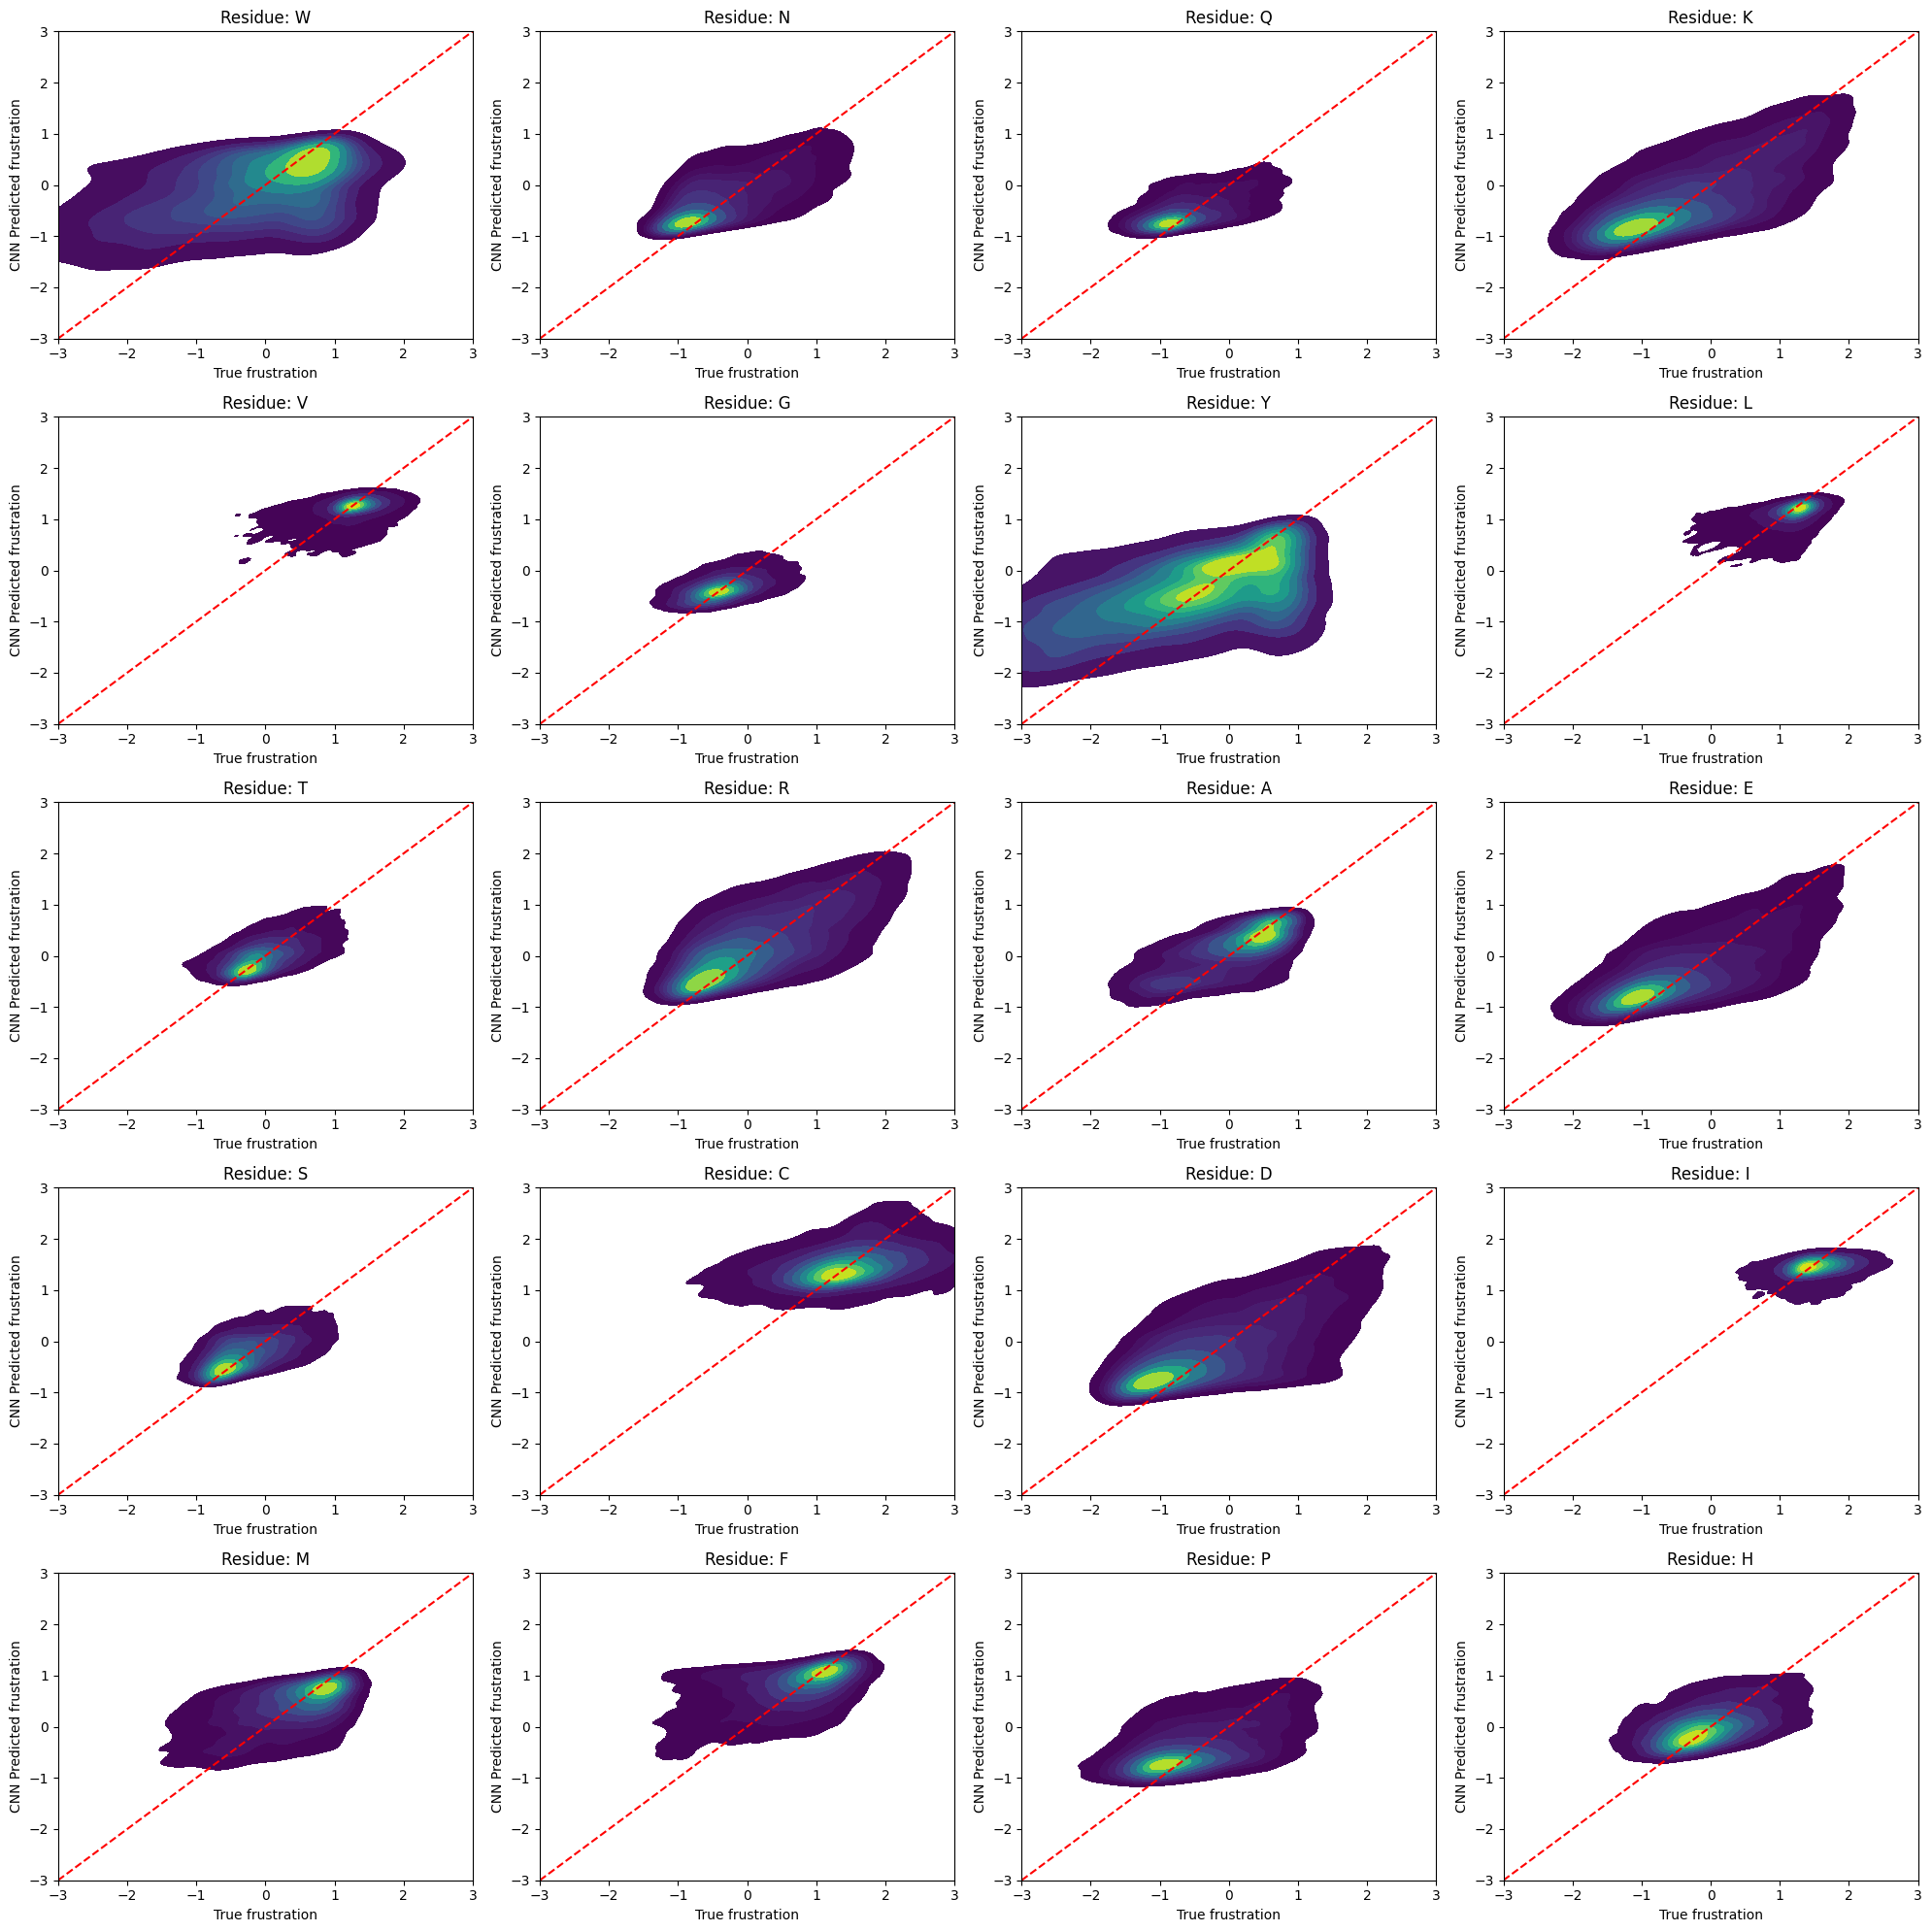

In [28]:
#make a fig with 20 subplots 5rows and 4 columns showing jointplots for each residue type
fig, axes = plt.subplots(5, 4, figsize=(20, 20))
residues = res_df_sub["residue"].unique()
for i, residue in enumerate(residues):
    ax = axes[i // 4, i % 4]
    subset = res_df_sub[res_df_sub["residue"] == residue]
    sns.kdeplot(data=subset, x="true_reg", y="regr_pred", fill=True, ax=ax, cmap="viridis")
    ax.plot([-3, 3], [-3, 3], color="red", linestyle="--")
    ax.set_title(f'Residue: {residue}')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_xlabel("True frustration")
    ax.set_ylabel("CNN Predicted frustration")
plt.tight_layout()
plt.show()

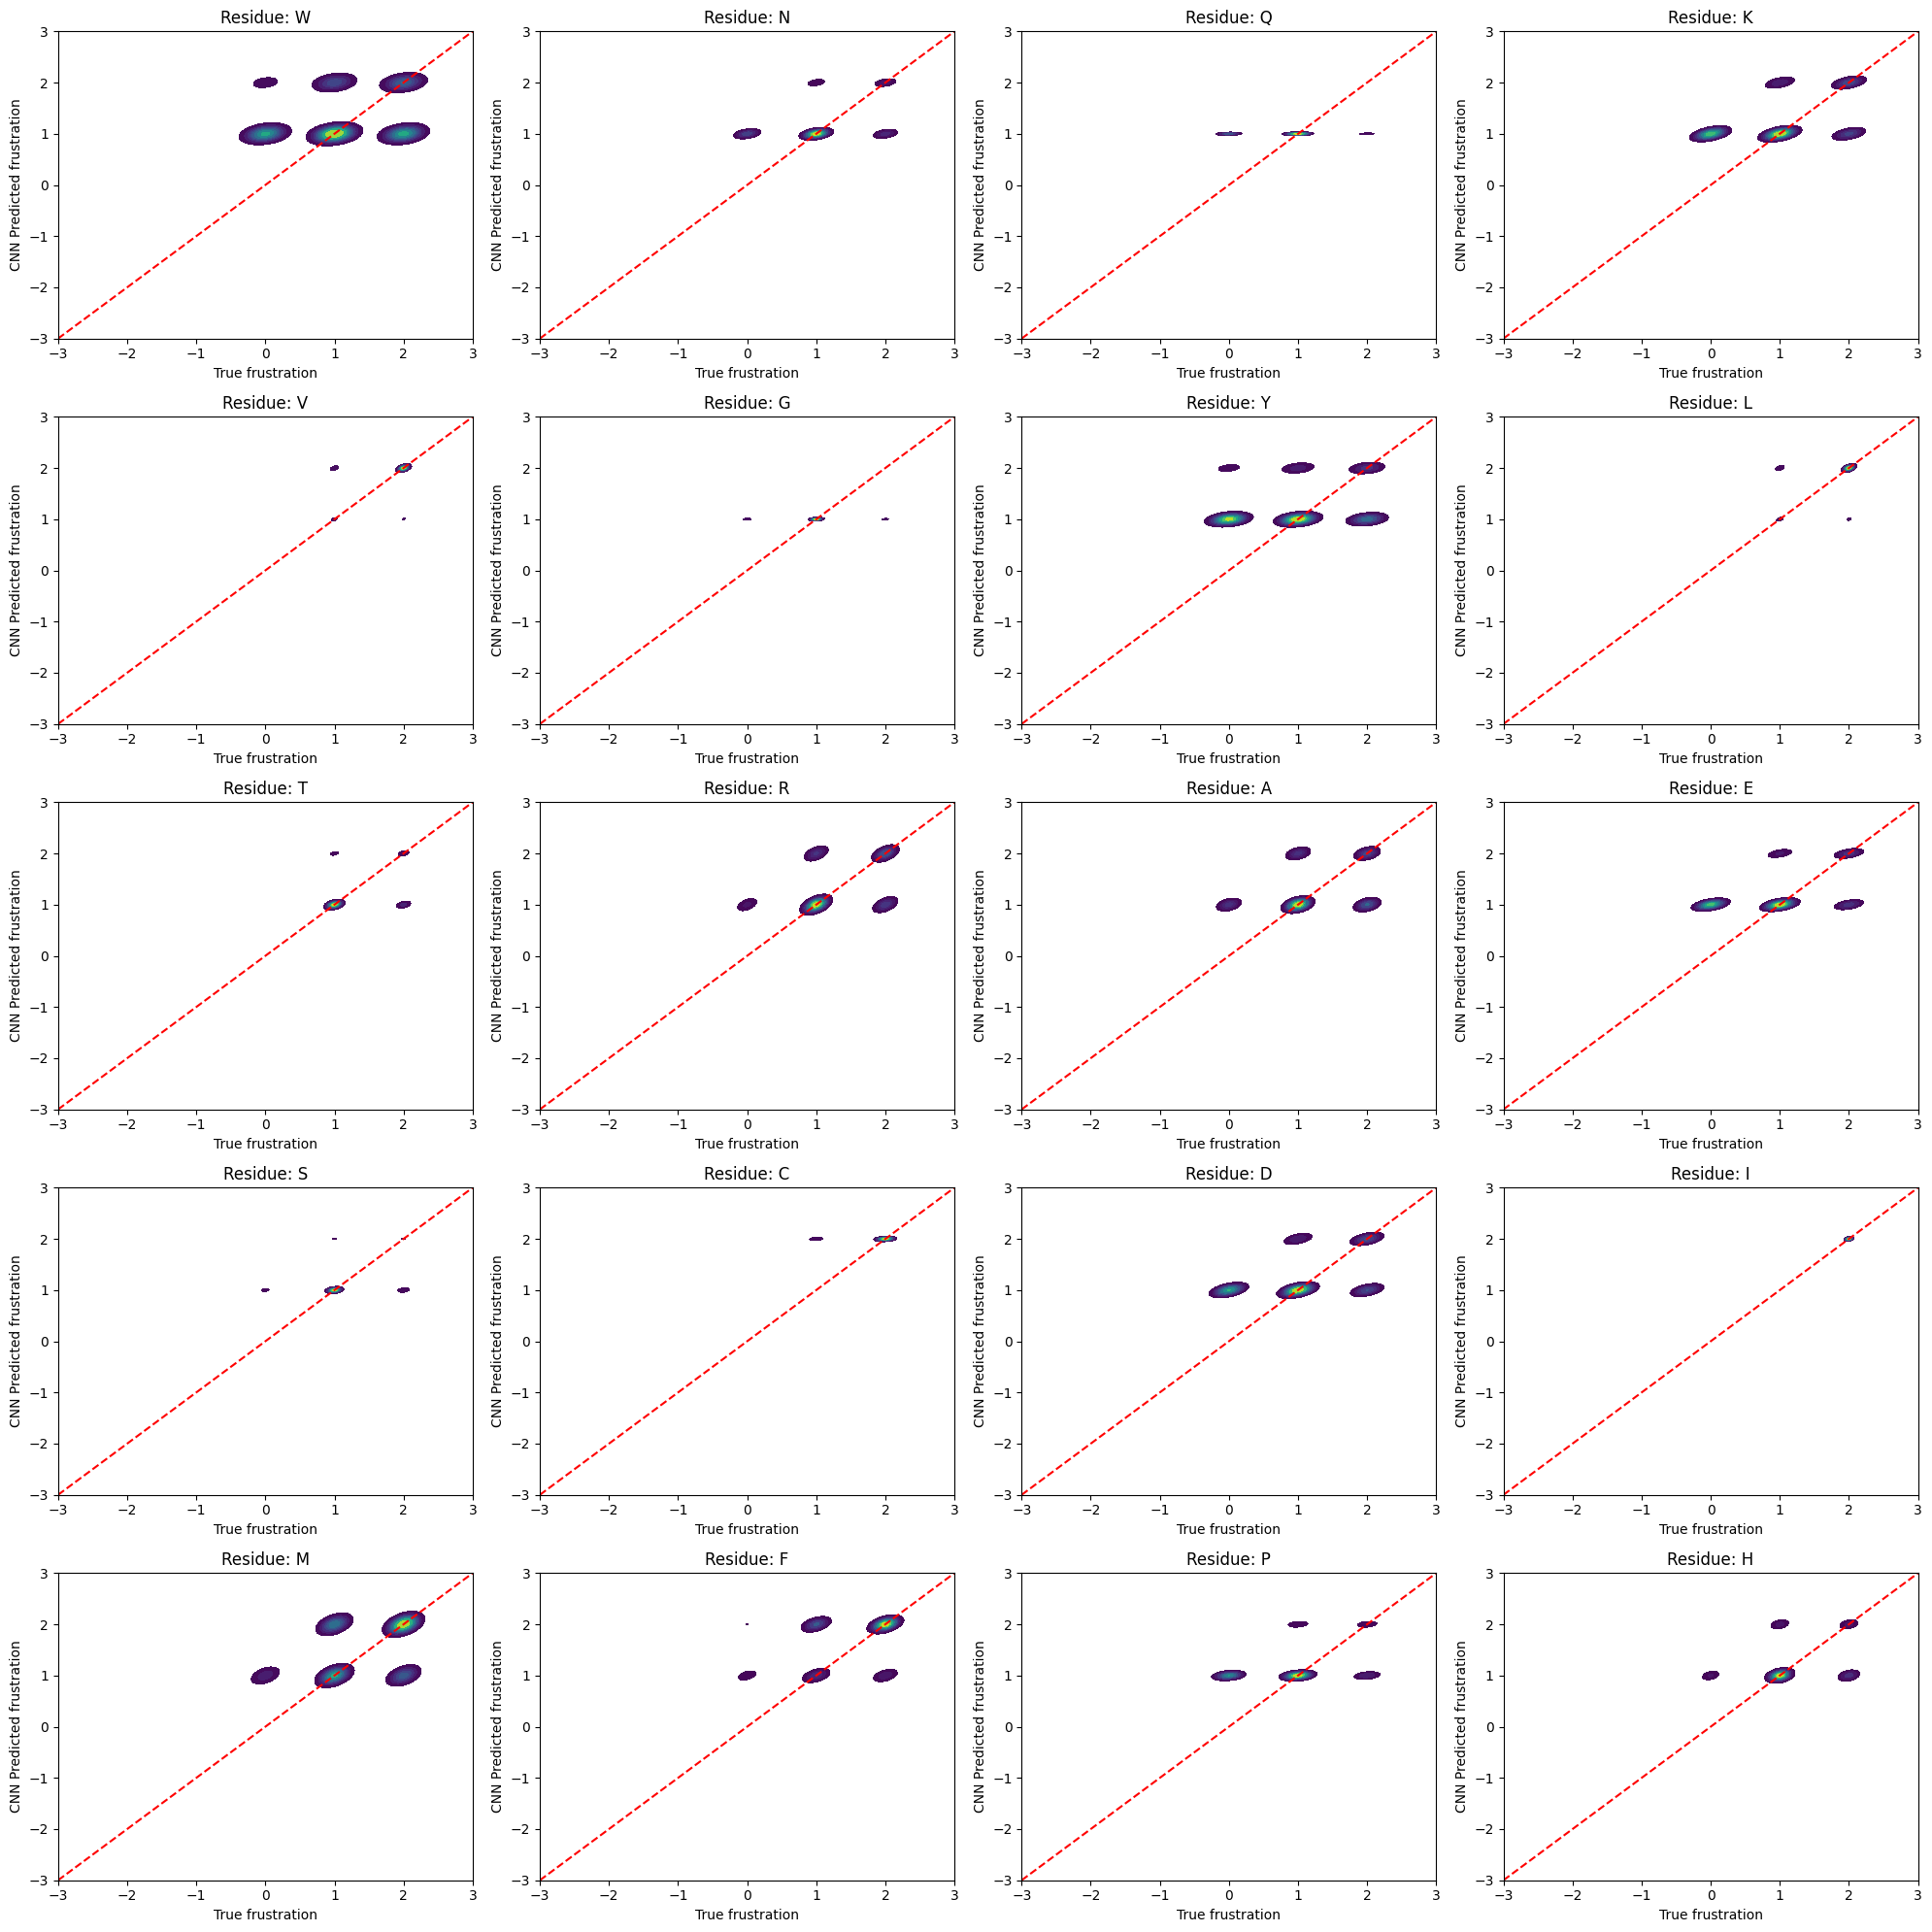

In [29]:
#make a fig with 20 subplots 5rows and 4 columns showing jointplots for each residue type
fig, axes = plt.subplots(5, 4, figsize=(20, 20))
residues = res_df_sub["residue"].unique()
for i, residue in enumerate(residues):
    ax = axes[i // 4, i % 4]
    subset = res_df_sub[res_df_sub["residue"] == residue]
    sns.kdeplot(data=subset, x="cls_target", y="cls_pred", fill=True, ax=ax, cmap="viridis")
    ax.plot([-3, 3], [-3, 3], color="red", linestyle="--")
    ax.set_title(f'Residue: {residue}')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_xlabel("True frustration")
    ax.set_ylabel("CNN Predicted frustration")
plt.tight_layout()
plt.show()

In [30]:
residues = res_df_sub["residue"].unique()
for i, residue in enumerate(residues):
    subset = res_df_sub[res_df_sub["residue"] == residue]
    cls_report = classification_report(subset["cls_target"], subset["cls_pred"], labels=range(3), digits=4, zero_division=0)
    print(f"Residue: {residue}")
    print(cls_report)

Residue: W
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      2832
           1     0.4694    0.8019    0.5921      5846
           2     0.5324    0.3680    0.4352      4242

    accuracy                         0.4837     12920
   macro avg     0.3339    0.3900    0.3424     12920
weighted avg     0.3872    0.4837    0.4108     12920

Residue: N
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      6894
           1     0.7562    0.9617    0.8467     34694
           2     0.6266    0.3680    0.4637      6146

    accuracy                         0.7464     47734
   macro avg     0.4609    0.4433    0.4368     47734
weighted avg     0.6303    0.7464    0.6751     47734

Residue: Q
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      7434
           1     0.7517    0.9958    0.8567     26040
           2     0.5363    0.1047    0.175

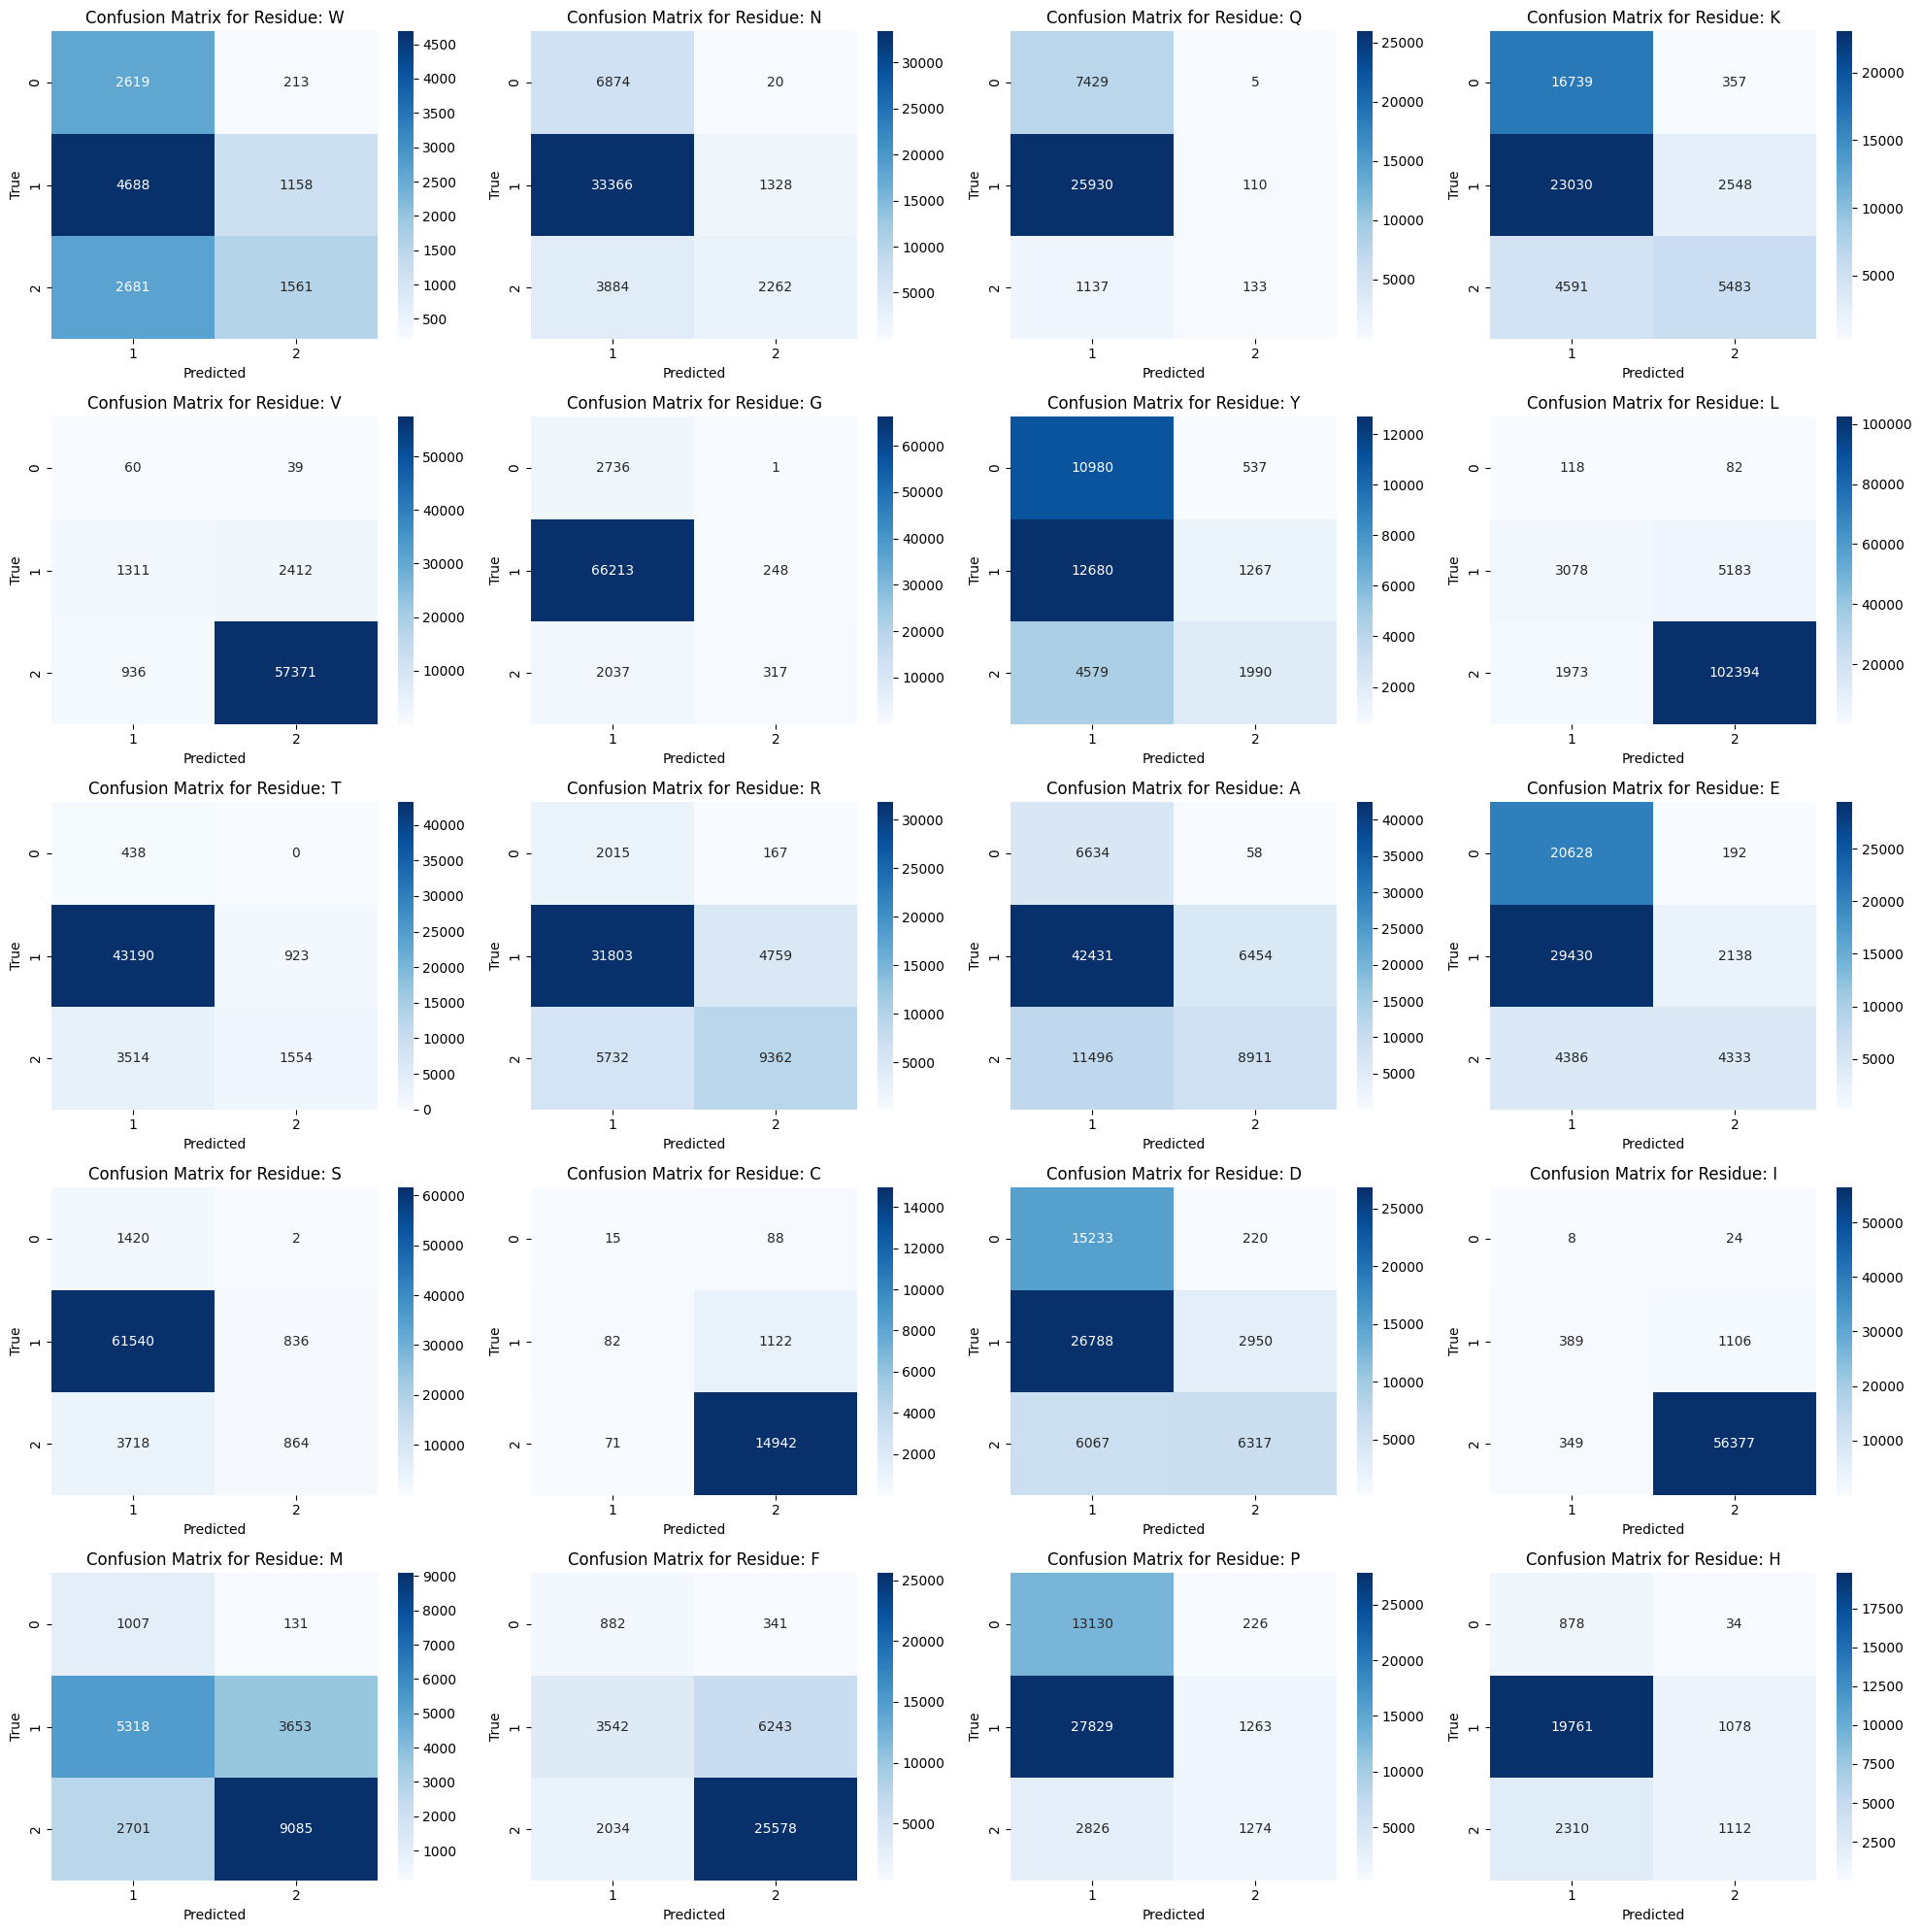

In [31]:
fig, axes = plt.subplots(5, 4, figsize=(20, 20))
residues = res_df_sub["residue"].unique()
for i, residue in enumerate(residues):
    subset = res_df_sub[res_df_sub["residue"] == residue]
    confusion_matrix = pd.crosstab(subset["cls_target"], subset["cls_pred"], rownames=['True'], colnames=['Predicted'])
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[i // 4, i % 4])
    axes[i // 4, i % 4].set_title(f'Confusion Matrix for Residue: {residue}')
plt.tight_layout()
plt.show()

### RANDOM SHUFFLE

In [18]:
CNN_test["masked_regr_targets"].shape

(9575120,)

In [19]:
shuffled_masked_targets_cls = np.random.permutation(CNN_test["masked_cls_targets"])
shuffled_masked_targets_regr = np.random.permutation(CNN_test["masked_regr_targets"])
shuffled_masked_targets_regr.shape, shuffled_masked_targets_cls.shape

((9575120,), (9575120,))

In [23]:
RND_report = classification_report(CNN_test["masked_cls_targets"], 
                                   shuffled_masked_targets_cls, 
                                   labels=range(3), digits=4, zero_division=0)

In [24]:
print(RND_report)

              precision    recall  f1-score   support

           0     0.1131    0.1131    0.1131   1079124
           1     0.5086    0.5086    0.5086   4868864
           2     0.3790    0.3790    0.3790   3627132

    accuracy                         0.4149   9575120
   macro avg     0.3336    0.3336    0.3336   9575120
weighted avg     0.4149    0.4149    0.4149   9575120



In [60]:
full_sequence = [np.array(["ABCE", "ABDEESA"]), np.array(["ACDASSDE", "ACDEFGH"])]
np.concatenate(full_sequence)


array(['ABCE', 'ABDEESA', 'ACDASSDE', 'ACDEFGH'], dtype='<U8')

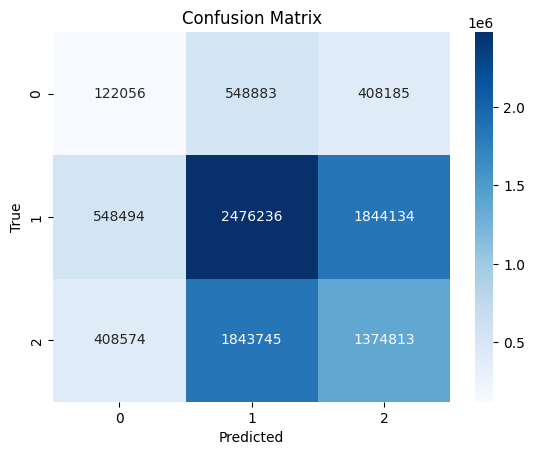

In [26]:
# make a confusion matrix
confusion_matrix = pd.crosstab(CNN_test["masked_cls_targets"], shuffled_masked_targets_cls, rownames=['True'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [27]:
spearmanr(CNN_test["masked_regr_targets"], shuffled_masked_targets_regr)

SignificanceResult(statistic=np.float64(-1.88806137965575e-05), pvalue=np.float64(0.9534112327952416))

In [28]:
mean_absolute_error(CNN_test["masked_regr_targets"], shuffled_masked_targets_regr)

1.1208008527755737

In [29]:
r2_score(CNN_test["masked_regr_targets"], shuffled_masked_targets_regr)

-1.000025749206543

Text(0, 0.5, 'RND Predicted frustration')

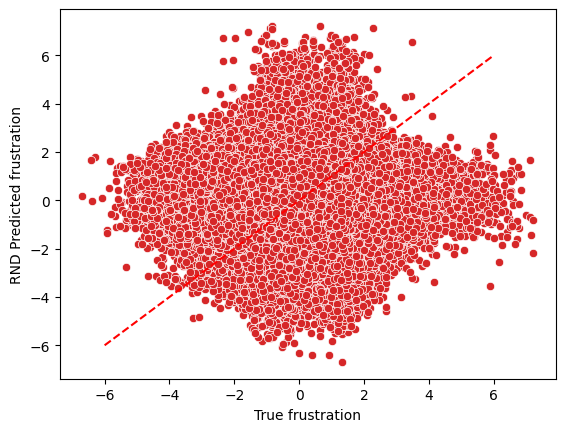

In [30]:
sns.scatterplot(x=CNN_test["masked_regr_targets"], y=shuffled_masked_targets_regr, color="C3")
plt.plot([-6, 6], [-6, 6], color="red", linestyle="--")
plt.xlabel("True frustration")
plt.ylabel("RND Predicted frustration")

Text(39.222222222222214, 0.5, 'RND Predicted frustration')

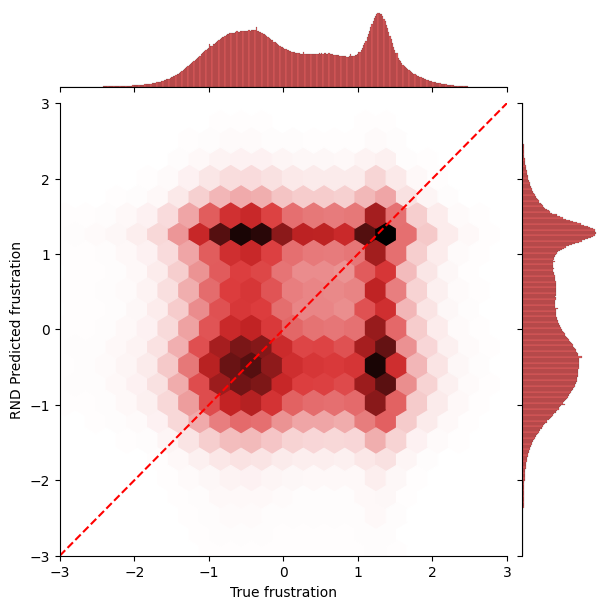

In [31]:
sns.jointplot(x=CNN_test["masked_regr_targets"], y=shuffled_masked_targets_regr, kind="hex", xlim=(-3,3), ylim=(-3,3), color="C3")
plt.plot([-3, 3], [-3, 3], color="red", linestyle="--")
plt.xlabel("True frustration")
plt.ylabel("RND Predicted frustration")

### JOINT PLOTS

In [41]:
#create combined dataframe for all models
df_FNN = pd.DataFrame({
    "true": FNN_test["masked_regr_targets"],
    "pred": FNN_test["masked_regr_preds"],
    "model": "FNN"
}).sample(n=100000, random_state=42)
df_CNN = pd.DataFrame({
    "true": CNN_test["masked_regr_targets"],
    "pred": CNN_test["masked_regr_preds"],
    "model": "CNN"
}).sample(n=100000, random_state=42)
df_LLR = pd.DataFrame({
    "true": LLR_test["masked_regr_targets"],
    "pred": LLR_test["masked_regr_preds"],
    "model": "LLR"
}).sample(n=100000, random_state=42)
df_RND = pd.DataFrame({
    "true": FNN_test["masked_regr_targets"],
    "pred": shuffled_masked_targets_regr,
    "model": "RND"
}).sample(n=100000, random_state=42)
df_combined = pd.concat([df_FNN, df_CNN, df_LLR, df_RND], ignore_index=True)
df_combined

,true,pred,model
0,-0.941,-0.779785,FNN
1,-0.280,-0.156982,FNN
2,-0.997,-0.545410,FNN
3,0.732,0.399414,FNN
4,1.699,-0.022629,FNN
...,...,...,...
399995,0.653,-0.172000,RND
399996,1.205,0.279000,RND
399997,-0.421,-0.391000,RND
399998,-1.085,1.239000,RND


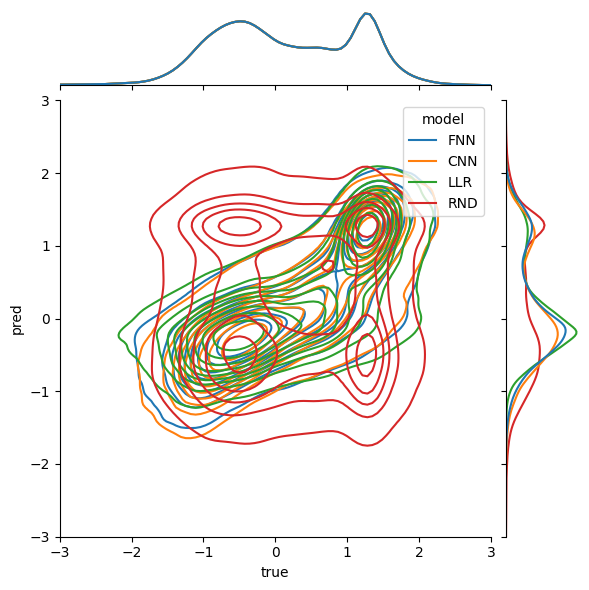

In [42]:
sns.jointplot(data=df_combined, x="true", y="pred", hue="model", kind="kde", xlim=(-3,3), ylim=(-3,3))

In [58]:
metrics = pd.read_csv("../data/it2/metrics.csv")
metrics.head()

,epoch,step,test_ce_loss,test_loss,test_mse_loss,train_ce_loss_epoch,train_ce_loss_step,train_loss_epoch,train_loss_step,train_mse_loss_epoch,train_mse_loss_step,val_ce_loss,val_loss,val_mse_loss
0,0,49,NaN,NaN,NaN,NaN,0.659562,NaN,1.151453,NaN,0.491891,NaN,NaN,NaN
1,0,99,NaN,NaN,NaN,NaN,0.629271,NaN,1.084710,NaN,0.455438,NaN,NaN,NaN
2,0,149,NaN,NaN,NaN,NaN,0.622892,NaN,1.068595,NaN,0.445703,NaN,NaN,NaN
3,0,199,NaN,NaN,NaN,NaN,0.614582,NaN,1.051796,NaN,0.437214,NaN,NaN,NaN
4,0,249,NaN,NaN,NaN,NaN,0.610273,NaN,1.050934,NaN,0.440661,NaN,NaN,NaN


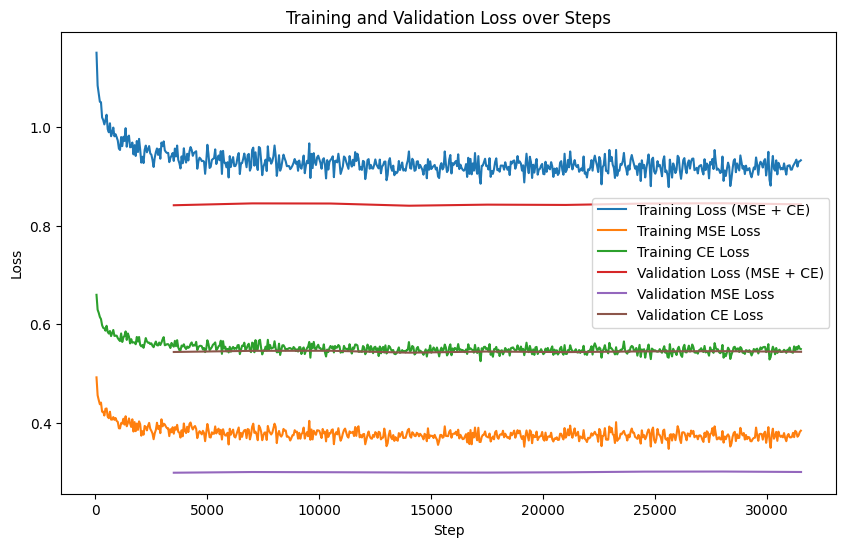

In [68]:
plt.figure(figsize=(10,6))
sns.lineplot(data=metrics, x="step", y="train_loss_step", label="Training Loss (MSE + CE)")
sns.lineplot(data=metrics, x="step", y="train_mse_loss_step", label="Training MSE Loss")
sns.lineplot(data=metrics, x="step", y="train_ce_loss_step", label="Training CE Loss")
sns.lineplot(data=metrics, x="step", y="val_loss", label="Validation Loss (MSE + CE)")
sns.lineplot(data=metrics, x="step", y="val_mse_loss", label="Validation MSE Loss")
sns.lineplot(data=metrics, x="step", y="val_ce_loss", label="Validation CE Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Steps")
plt.legend()
plt.show()